## 1. Libraries 📖

In [6]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import json 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [7]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [8]:
df_train = pd.read_csv("../../data/train/cardio/cardio_pubchem_train.csv")
df_test = pd.read_csv("../../data/train/cardio/cardio_pubchem_test.csv")
df_valid = pd.read_csv("../../data/train/cardio/cardio_pubchem_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [9]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'pIC50']
y_train_all = df_train_all['pIC50']

X_train = df_train.loc[:, df_train.columns != 'pIC50']
y_train = df_train['pIC50']

X_test = df_test.loc[:, df_test.columns != 'pIC50']
y_test = df_test['pIC50']

X_valid = df_valid.loc[:, df_valid.columns != 'pIC50']
y_valid = df_valid['pIC50']

In [10]:
with open('../../pubchem_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train_all = X_train_all[idxs['cardio']]
X_train = X_train[idxs['cardio']]
X_test = X_test[idxs['cardio']]
X_valid = X_valid[idxs['cardio']]

In [11]:
X_train.shape

(7442, 472)

In [12]:
X_test.shape

(2127, 472)

In [13]:
X_valid.shape

(1063, 472)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [14]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(472, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [16]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [17]:
best_value = 1
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=1063, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 3.4120888423510376, Accuracy: -3.320479989772381
Test Avg. loss: 1.1620545387268066, Accuracy: -0.3653283239676861
################## EPOCH 2 ##################
Train Avg. loss: 2.667416489687089, Accuracy: -2.2839105518013367
Test Avg. loss: 1.6152390241622925, Accuracy: -0.8977866853929886
################## EPOCH 3 ##################
Train Avg. loss: 2.568368895371073, Accuracy: -2.1395450903413087
Test Avg. loss: 0.9940521717071533, Accuracy: -0.16793788655235398
################## EPOCH 4 ##################
Train Avg. loss: 2.378159457521889, Accuracy: -1.9330676700756058
Test Avg. loss: 1.0367244482040405, Accuracy: -0.2180745692228705
################## EPOCH 5 ##################
Train Avg. loss: 2.273625935096086, Accuracy: -1.777253441525825
Test Avg. loss: 0.978682816028595, Accuracy: -0.14988007794386848
################## EPOCH 6 ##################
Train Avg. loss: 2.18890274798921

Train Avg. loss: 0.6837292327645511, Accuracy: 0.20368639611489797
Test Avg. loss: 0.6448261141777039, Accuracy: 0.24237684813381
################## EPOCH 48 ##################
Train Avg. loss: 0.671370746943572, Accuracy: 0.2131921687335164
Test Avg. loss: 0.6282155513763428, Accuracy: 0.2618930807754166
################## EPOCH 49 ##################
Train Avg. loss: 0.6790708671823592, Accuracy: 0.2063534027907678
Test Avg. loss: 0.6454644203186035, Accuracy: 0.24162698438626184
################## EPOCH 50 ##################
Train Avg. loss: 0.6670974629887184, Accuracy: 0.22039978571257648
Test Avg. loss: 0.6364094018936157, Accuracy: 0.2522659648439366
################## EPOCH 51 ##################
Train Avg. loss: 0.6626476208667387, Accuracy: 0.2230162891629435
Test Avg. loss: 0.6302762627601624, Accuracy: 0.25947188466506343
################## EPOCH 52 ##################
Train Avg. loss: 0.652538162380329, Accuracy: 0.23015906922724813
Test Avg. loss: 0.6386153697967529, Accurac

Train Avg. loss: 0.5762552753282719, Accuracy: 0.3253677800519337
Test Avg. loss: 0.6204589009284973, Accuracy: 0.27100663715775386
################## EPOCH 94 ##################
Train Avg. loss: 0.5643663257999993, Accuracy: 0.33574431083772016
Test Avg. loss: 0.6264572739601135, Accuracy: 0.2639589828350234
################## EPOCH 95 ##################
Train Avg. loss: 0.5584800354017209, Accuracy: 0.34070747138426904
Test Avg. loss: 0.6404828429222107, Accuracy: 0.24747990602706393
################## EPOCH 96 ##################
Train Avg. loss: 0.5608120696227438, Accuracy: 0.34009900897355344
Test Avg. loss: 0.6215934157371521, Accuracy: 0.2696736489947167
################## EPOCH 97 ##################
Train Avg. loss: 0.5591939570694011, Accuracy: 0.34387146810918223
Test Avg. loss: 0.6402423977851868, Accuracy: 0.24776243613824545
################## EPOCH 98 ##################
Train Avg. loss: 0.5642520560855006, Accuracy: 0.33628123115530933
Test Avg. loss: 0.6400721669197083, 

Train Avg. loss: 0.5040358315849509, Accuracy: 0.3987775160682059
Test Avg. loss: 0.6344452500343323, Accuracy: 0.2545736837453615
################## EPOCH 140 ##################
Train Avg. loss: 0.5086472887593789, Accuracy: 0.3968282397670621
Test Avg. loss: 0.6106148958206177, Accuracy: 0.2825726136792801
################## EPOCH 141 ##################
Train Avg. loss: 0.5177265164550282, Accuracy: 0.3915149617914448
Test Avg. loss: 0.6388952136039734, Accuracy: 0.24934531731696263
################## EPOCH 142 ##################
Train Avg. loss: 0.5152594082601081, Accuracy: 0.3904061063984163
Test Avg. loss: 0.6221192479133606, Accuracy: 0.26905580894620595
################## EPOCH 143 ##################
Train Avg. loss: 0.5041592199147515, Accuracy: 0.400268304140883
Test Avg. loss: 0.6087948083877563, Accuracy: 0.2847110724687383
################## EPOCH 144 ##################
Train Avg. loss: 0.502248431607889, Accuracy: 0.4070208505348206
Test Avg. loss: 0.6192243695259094, Acc

Train Avg. loss: 0.46885150274493664, Accuracy: 0.45075837233702376
Test Avg. loss: 0.6364428400993347, Accuracy: 0.2522266149636623
################## EPOCH 186 ##################
Train Avg. loss: 0.4676589198378534, Accuracy: 0.4484607119578837
Test Avg. loss: 0.6267304420471191, Accuracy: 0.2636379475202657
################## EPOCH 187 ##################
Train Avg. loss: 0.4746938360926931, Accuracy: 0.4395738156260127
Test Avg. loss: 0.6223750710487366, Accuracy: 0.2687552035633567
################## EPOCH 188 ##################
Train Avg. loss: 0.4734891320502809, Accuracy: 0.44193809051677124
Test Avg. loss: 0.6168127655982971, Accuracy: 0.2752904871137941
################## EPOCH 189 ##################
Train Avg. loss: 0.4751686497307642, Accuracy: 0.4304118171824479
Test Avg. loss: 0.6236063838005066, Accuracy: 0.26730847593988705
################## EPOCH 190 ##################
Train Avg. loss: 0.4718547052196167, Accuracy: 0.4433835876204982
Test Avg. loss: 0.6287172436714172,

Train Avg. loss: 0.44752053782152, Accuracy: 0.4665590934814466
Test Avg. loss: 0.6153659224510193, Accuracy: 0.27699046953052897
################## EPOCH 232 ##################
Train Avg. loss: 0.44425841315365655, Accuracy: 0.4755315529423046
Test Avg. loss: 0.642855167388916, Accuracy: 0.24469262711461737
################## EPOCH 233 ##################
Train Avg. loss: 0.4371344095391777, Accuracy: 0.47776388823577276
Test Avg. loss: 0.6264002919197083, Accuracy: 0.26402585144289714
################## EPOCH 234 ##################
Train Avg. loss: 0.46044101223925155, Accuracy: 0.4591530120298635
Test Avg. loss: 0.6307532787322998, Accuracy: 0.25891150780707495
################## EPOCH 235 ##################
Train Avg. loss: 0.4429587264557253, Accuracy: 0.47121822854851714
Test Avg. loss: 0.6317614316940308, Accuracy: 0.2577269355153342
################## EPOCH 236 ##################
Train Avg. loss: 0.4429649480422679, Accuracy: 0.47060798801527315
Test Avg. loss: 0.648679852485656

Train Avg. loss: 0.4340401766382062, Accuracy: 0.48533541958430626
Test Avg. loss: 0.6310876607894897, Accuracy: 0.2585185595252455
################## EPOCH 278 ##################
Train Avg. loss: 0.4286894003976568, Accuracy: 0.4931319444882078
Test Avg. loss: 0.632275402545929, Accuracy: 0.25712308667397166
################## EPOCH 279 ##################
Train Avg. loss: 0.4322415177786299, Accuracy: 0.48252150518284126
Test Avg. loss: 0.6313517093658447, Accuracy: 0.2582083327063285
################## EPOCH 280 ##################
Train Avg. loss: 0.4299803560383842, Accuracy: 0.48603466187031397
Test Avg. loss: 0.6306473612785339, Accuracy: 0.2590358389541665
################## EPOCH 281 ##################
Train Avg. loss: 0.4262456593659303, Accuracy: 0.49644700485134835
Test Avg. loss: 0.6412731409072876, Accuracy: 0.24655136195372218
################## EPOCH 282 ##################
Train Avg. loss: 0.4274598529218604, Accuracy: 0.48976230019442063
Test Avg. loss: 0.655503094196319

Train Avg. loss: 1.495311085994427, Accuracy: -0.7182518169068574
Test Avg. loss: 0.9774722456932068, Accuracy: -0.1484576219978453
################## EPOCH 24 ##################
Train Avg. loss: 1.4220528235802283, Accuracy: -0.6452592457939156
Test Avg. loss: 1.2213906049728394, Accuracy: -0.43504382229605576
################## EPOCH 25 ##################
Train Avg. loss: 1.3824345337020025, Accuracy: -0.5835528296288239
Test Avg. loss: 0.8912084698677063, Accuracy: -0.04710415897783071
################## EPOCH 26 ##################
Train Avg. loss: 1.4154644292643948, Accuracy: -0.6235975007085767
Test Avg. loss: 0.9298621416091919, Accuracy: -0.09251942969085691
################## EPOCH 27 ##################
Train Avg. loss: 1.3162237899935143, Accuracy: -0.5105356258957425
Test Avg. loss: 1.0328938961029053, Accuracy: -0.21357402643713552
################## EPOCH 28 ##################
Train Avg. loss: 1.354594372276567, Accuracy: -0.5720481130625557
Test Avg. loss: 0.9013103842735

Train Avg. loss: 0.6823900874353882, Accuracy: 0.2249225063335099
Test Avg. loss: 0.6371583342552185, Accuracy: 0.2513859505568653
################## EPOCH 70 ##################
Train Avg. loss: 0.6857646358573538, Accuracy: 0.2257430882655669
Test Avg. loss: 0.6308512091636658, Accuracy: 0.25879632976396316
################## EPOCH 71 ##################
Train Avg. loss: 0.6596707462245582, Accuracy: 0.2501569189527288
Test Avg. loss: 0.6254595518112183, Accuracy: 0.2651311768232175
################## EPOCH 72 ##################
Train Avg. loss: 0.6669149551636133, Accuracy: 0.24517904241280142
Test Avg. loss: 0.622230589389801, Accuracy: 0.26892501691458903
################## EPOCH 73 ##################
Train Avg. loss: 0.6596968077186846, Accuracy: 0.24812405470446763
Test Avg. loss: 0.6268681287765503, Accuracy: 0.26347622865797227
################## EPOCH 74 ##################
Train Avg. loss: 0.6467430285918407, Accuracy: 0.2594344308686014
Test Avg. loss: 0.6129144430160522, Accu

Train Avg. loss: 0.5310228843974252, Accuracy: 0.40371780157773646
Test Avg. loss: 0.6196072697639465, Accuracy: 0.2720072090980684
################## EPOCH 116 ##################
Train Avg. loss: 0.535397931551322, Accuracy: 0.3988790044468088
Test Avg. loss: 0.621836245059967, Accuracy: 0.2693882963132671
################## EPOCH 117 ##################
Train Avg. loss: 0.5388426248334411, Accuracy: 0.3899195934232855
Test Avg. loss: 0.6124600768089294, Accuracy: 0.2804046163891536
################## EPOCH 118 ##################
Train Avg. loss: 0.5350586011623725, Accuracy: 0.3872220156195534
Test Avg. loss: 0.6170955300331116, Accuracy: 0.2749583878981
################## EPOCH 119 ##################
Train Avg. loss: 0.5384755509021955, Accuracy: 0.3943663708941298
Test Avg. loss: 0.6135631799697876, Accuracy: 0.2791086296165981
################## EPOCH 120 ##################
Train Avg. loss: 0.5264427381702977, Accuracy: 0.4067830213398945
Test Avg. loss: 0.6081749200820923, Accurac

Train Avg. loss: 0.4907120643263189, Accuracy: 0.44035681406593263
Test Avg. loss: 0.6164711713790894, Accuracy: 0.2756919068065977
################## EPOCH 162 ##################
Train Avg. loss: 0.4861289846082019, Accuracy: 0.4484874803601236
Test Avg. loss: 0.6276833415031433, Accuracy: 0.2625184362363312
################## EPOCH 163 ##################
Train Avg. loss: 0.4857721529964708, Accuracy: 0.4528332808055131
Test Avg. loss: 0.6168060302734375, Accuracy: 0.27529845294964694
################## EPOCH 164 ##################
Train Avg. loss: 0.47950706904769963, Accuracy: 0.458603924953564
Test Avg. loss: 0.6199787855148315, Accuracy: 0.27157064455864255
################## EPOCH 165 ##################
Train Avg. loss: 0.502123064464993, Accuracy: 0.4344796590883158
Test Avg. loss: 0.6158816814422607, Accuracy: 0.2763844475980426
################## EPOCH 166 ##################
Train Avg. loss: 0.4769986655212875, Accuracy: 0.46030350548764265
Test Avg. loss: 0.6210989356040955, 

Train Avg. loss: 0.43750752037406987, Accuracy: 0.5044365859365609
Test Avg. loss: 0.6384038329124451, Accuracy: 0.24992266751781467
################## EPOCH 208 ##################
Train Avg. loss: 0.4512427968856616, Accuracy: 0.48737658696844904
Test Avg. loss: 0.6311700940132141, Accuracy: 0.25842168676476307
################## EPOCH 209 ##################
Train Avg. loss: 0.440713601361992, Accuracy: 0.5010608120106386
Test Avg. loss: 0.6254749298095703, Accuracy: 0.2651130586755367
################## EPOCH 210 ##################
Train Avg. loss: 0.45474057116060174, Accuracy: 0.4858571398603347
Test Avg. loss: 0.6355671882629395, Accuracy: 0.2532555585806082
################## EPOCH 211 ##################
Train Avg. loss: 0.4536343918651597, Accuracy: 0.4869021155066054
Test Avg. loss: 0.636859118938446, Accuracy: 0.2517375034593441
################## EPOCH 212 ##################
Train Avg. loss: 0.4427285270813184, Accuracy: 0.5020659276228157
Test Avg. loss: 0.6441757082939148, 

Train Avg. loss: 0.4235538768972087, Accuracy: 0.5261131067696095
Test Avg. loss: 0.6442729830741882, Accuracy: 0.24302681433549977
################## EPOCH 254 ##################
Train Avg. loss: 0.4150538419683774, Accuracy: 0.5302029022689094
Test Avg. loss: 0.6362385153770447, Accuracy: 0.2524667963131101
################## EPOCH 255 ##################
Train Avg. loss: 0.4271749042802387, Accuracy: 0.5149663884464187
Test Avg. loss: 0.6374145150184631, Accuracy: 0.2510849558189645
################## EPOCH 256 ##################
Train Avg. loss: 0.4229383491552793, Accuracy: 0.5262790138384108
Test Avg. loss: 0.6435118913650513, Accuracy: 0.24392103916279295
################## EPOCH 257 ##################
Train Avg. loss: 0.4305036675471526, Accuracy: 0.5128984895650069
Test Avg. loss: 0.6354400515556335, Accuracy: 0.2534048654413077
################## EPOCH 258 ##################
Train Avg. loss: 0.42902762417355156, Accuracy: 0.5139238367226827
Test Avg. loss: 0.6411203742027283, 

Train Avg. loss: 0.4183198775873225, Accuracy: 0.5264149504470069
Test Avg. loss: 0.656649112701416, Accuracy: 0.22848580079166414
################## EPOCH 300 ##################
Train Avg. loss: 0.40210806215420747, Accuracy: 0.5459481073139203
Test Avg. loss: 0.6508707404136658, Accuracy: 0.23527495974996537
Model: lr 0.001, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 4.846106160495241, Accuracy: -4.573440454562069
Test Avg. loss: 2.3662238121032715, Accuracy: -1.780138222895793
################## EPOCH 2 ##################
Train Avg. loss: 2.632205328698886, Accuracy: -2.032593930981251
Test Avg. loss: 1.6144938468933105, Accuracy: -0.8969111767530904
################## EPOCH 3 ##################
Train Avg. loss: 2.6193133471375805, Accuracy: -2.014062311554841
Test Avg. loss: 1.5044199228286743, Accuracy: -0.7675823159592385
################## EPOCH 4 ##################
Train Avg. loss: 2.631974501124883, Accuracy: -2.0486723613958704
Test Avg. los

Train Avg. loss: 1.4838463492312675, Accuracy: -0.7211521716793982
Test Avg. loss: 1.358755111694336, Accuracy: -0.5964369025793936
################## EPOCH 46 ##################
Train Avg. loss: 1.5028222465919236, Accuracy: -0.7111241380424856
Test Avg. loss: 1.2185680866241455, Accuracy: -0.4317276379110846
################## EPOCH 47 ##################
Train Avg. loss: 1.429999726303553, Accuracy: -0.6250114684999222
Test Avg. loss: 1.2386698722839355, Accuracy: -0.4553456743780899
################## EPOCH 48 ##################
Train Avg. loss: 1.443164325366586, Accuracy: -0.6475321958356852
Test Avg. loss: 1.1922643184661865, Accuracy: -0.4008225436998021
################## EPOCH 49 ##################
Train Avg. loss: 1.4164199061312919, Accuracy: -0.644284083667416
Test Avg. loss: 1.3582960367202759, Accuracy: -0.5958975707435752
################## EPOCH 50 ##################
Train Avg. loss: 1.3941417841588037, Accuracy: -0.5804119741877429
Test Avg. loss: 0.9523872137069702, A

Train Avg. loss: 0.8310691921387688, Accuracy: 0.061109488022809376
Test Avg. loss: 0.7033894658088684, Accuracy: 0.17356931051470847
################## EPOCH 92 ##################
Train Avg. loss: 0.8071608502986067, Accuracy: 0.08371713293823894
Test Avg. loss: 0.6791703104972839, Accuracy: 0.2020249910254227
################## EPOCH 93 ##################
Train Avg. loss: 0.8054797108900749, Accuracy: 0.09274525977139648
Test Avg. loss: 0.7031915783882141, Accuracy: 0.17380180663849132
################## EPOCH 94 ##################
Train Avg. loss: 0.7800220432928053, Accuracy: 0.10569260683408971
Test Avg. loss: 0.7066577672958374, Accuracy: 0.1697293125449919
################## EPOCH 95 ##################
Train Avg. loss: 0.7878131810891427, Accuracy: 0.10351362805970293
Test Avg. loss: 0.6847708821296692, Accuracy: 0.19544477600906385
################## EPOCH 96 ##################
Train Avg. loss: 0.7616257786245669, Accuracy: 0.1516249257444952
Test Avg. loss: 0.6855063438415527,

Train Avg. loss: 0.5509759244524827, Accuracy: 0.38340209992650087
Test Avg. loss: 0.6283115148544312, Accuracy: 0.26178037995991066
################## EPOCH 138 ##################
Train Avg. loss: 0.5647983485359257, Accuracy: 0.36517456457645775
Test Avg. loss: 0.6219263076782227, Accuracy: 0.26928247987956266
################## EPOCH 139 ##################
Train Avg. loss: 0.56122825534667, Accuracy: 0.3719773470151831
Test Avg. loss: 0.6359295845031738, Accuracy: 0.25282966944696716
################## EPOCH 140 ##################
Train Avg. loss: 0.5577294005680893, Accuracy: 0.374382663415416
Test Avg. loss: 0.6223623156547546, Accuracy: 0.26877016745517246
################## EPOCH 141 ##################
Train Avg. loss: 0.548399325144493, Accuracy: 0.38123541659472676
Test Avg. loss: 0.6282908320426941, Accuracy: 0.2618046509660976
################## EPOCH 142 ##################
Train Avg. loss: 0.5331887506832511, Accuracy: 0.3999860653730122
Test Avg. loss: 0.632498562335968, A

Train Avg. loss: 0.49926612968161954, Accuracy: 0.440550993194101
Test Avg. loss: 0.6283776760101318, Accuracy: 0.26170267037740325
################## EPOCH 184 ##################
Train Avg. loss: 0.480057511415522, Accuracy: 0.4626201045313977
Test Avg. loss: 0.6331431269645691, Accuracy: 0.256103593474741
################## EPOCH 185 ##################
Train Avg. loss: 0.49013693075058823, Accuracy: 0.4537875759947751
Test Avg. loss: 0.6267369389533997, Accuracy: 0.26363033544683867
################## EPOCH 186 ##################
Train Avg. loss: 0.49202121055479775, Accuracy: 0.4505115876053617
Test Avg. loss: 0.6255781054496765, Accuracy: 0.2649919237553541
################## EPOCH 187 ##################
Train Avg. loss: 0.4818770118941695, Accuracy: 0.46151743720733784
Test Avg. loss: 0.6275061964988708, Accuracy: 0.2627264863073707
################## EPOCH 188 ##################
Train Avg. loss: 0.4764674519962173, Accuracy: 0.4695675666848828
Test Avg. loss: 0.6120867729187012, 

Train Avg. loss: 0.45580278248605083, Accuracy: 0.4861673780074654
Test Avg. loss: 0.6322824358940125, Accuracy: 0.25711482442318834
################## EPOCH 230 ##################
Train Avg. loss: 0.4514561330868026, Accuracy: 0.4869265886110942
Test Avg. loss: 0.6317081451416016, Accuracy: 0.2577895682713751
################## EPOCH 231 ##################
Train Avg. loss: 0.43999778845552673, Accuracy: 0.5064985887051557
Test Avg. loss: 0.6262956261634827, Accuracy: 0.26414888907188994
################## EPOCH 232 ##################
Train Avg. loss: 0.4426164523524753, Accuracy: 0.5075142878623641
Test Avg. loss: 0.6247974038124084, Accuracy: 0.2659091518213973
################## EPOCH 233 ##################
Train Avg. loss: 0.44484118062813405, Accuracy: 0.5049291276452612
Test Avg. loss: 0.6054071187973022, Accuracy: 0.28869129389429204
################## EPOCH 234 ##################
Train Avg. loss: 0.45258878531344865, Accuracy: 0.49468084419137365
Test Avg. loss: 0.6286326646804

Train Avg. loss: 0.4323152268336991, Accuracy: 0.5138659012842428
Test Avg. loss: 0.6346243619918823, Accuracy: 0.25436319616528524
################## EPOCH 276 ##################
Train Avg. loss: 0.43734358869871853, Accuracy: 0.510217861503171
Test Avg. loss: 0.6283309459686279, Accuracy: 0.2617575248765174
################## EPOCH 277 ##################
Train Avg. loss: 0.4237791765796936, Accuracy: 0.5255421184647058
Test Avg. loss: 0.630976676940918, Accuracy: 0.25864898654835333
################## EPOCH 278 ##################
Train Avg. loss: 0.4183766391065161, Accuracy: 0.5330525611210997
Test Avg. loss: 0.6158478260040283, Accuracy: 0.27642426109048446
################## EPOCH 279 ##################
Train Avg. loss: 0.41510753219915647, Accuracy: 0.5314522308812368
Test Avg. loss: 0.6244895458221436, Accuracy: 0.26627089691306016
################## EPOCH 280 ##################
Train Avg. loss: 0.4302428530181869, Accuracy: 0.5177649231796665
Test Avg. loss: 0.6400228142738342,

Train Avg. loss: 1.9484985589981079, Accuracy: -1.2222109486719297
Test Avg. loss: 1.208713173866272, Accuracy: -0.420148677710944
################## EPOCH 22 ##################
Train Avg. loss: 1.9310514410336812, Accuracy: -1.269932940776723
Test Avg. loss: 1.0440492630004883, Accuracy: -0.22668079057506385
################## EPOCH 23 ##################
Train Avg. loss: 1.9341970245043436, Accuracy: -1.285221175215408
Test Avg. loss: 1.0917272567749023, Accuracy: -0.2826990197775998
################## EPOCH 24 ##################
Train Avg. loss: 1.9277204632759095, Accuracy: -1.22035318551496
Test Avg. loss: 1.0196139812469482, Accuracy: -0.19797119787912676
################## EPOCH 25 ##################
Train Avg. loss: 1.8738999684651694, Accuracy: -1.1983350780461908
Test Avg. loss: 1.5218603610992432, Accuracy: -0.7880735255880922
################## EPOCH 26 ##################
Train Avg. loss: 1.8325563708941142, Accuracy: -1.161780577195978
Test Avg. loss: 1.1135486364364624, Ac

Train Avg. loss: 1.4038381397724151, Accuracy: -0.6307655027972127
Test Avg. loss: 1.066882610321045, Accuracy: -0.2535083191609062
################## EPOCH 68 ##################
Train Avg. loss: 1.42021830479304, Accuracy: -0.6428030630664326
Test Avg. loss: 1.3119720220565796, Accuracy: -0.5414702602843235
################## EPOCH 69 ##################
Train Avg. loss: 1.3729143798351289, Accuracy: -0.6074482516851616
Test Avg. loss: 1.2007570266723633, Accuracy: -0.4108008524955531
################## EPOCH 70 ##################
Train Avg. loss: 1.3733977923790615, Accuracy: -0.5652172979382343
Test Avg. loss: 1.1614799499511719, Accuracy: -0.3646531987844519
################## EPOCH 71 ##################
Train Avg. loss: 1.390604317188263, Accuracy: -0.6423489750989658
Test Avg. loss: 1.0138052701950073, Accuracy: -0.19114657045289762
################## EPOCH 72 ##################
Train Avg. loss: 1.3900385518868765, Accuracy: -0.625624240958705
Test Avg. loss: 1.1737371683120728, A

Train Avg. loss: 1.0057106971740724, Accuracy: -0.16204364535402693
Test Avg. loss: 0.7782211303710938, Accuracy: 0.08564759498883912
################## EPOCH 114 ##################
Train Avg. loss: 1.0202602803707124, Accuracy: -0.19318424863336361
Test Avg. loss: 0.8756232857704163, Accuracy: -0.02879266845784967
################## EPOCH 115 ##################
Train Avg. loss: 1.0064080943663916, Accuracy: -0.1474261307101732
Test Avg. loss: 0.7529814839363098, Accuracy: 0.11530235759481033
################## EPOCH 116 ##################
Train Avg. loss: 0.9969459474086761, Accuracy: -0.1893102596382828
Test Avg. loss: 0.7528530359268188, Accuracy: 0.11545328285603429
################## EPOCH 117 ##################
Train Avg. loss: 1.0073266605536142, Accuracy: -0.19234356447471038
Test Avg. loss: 0.737998366355896, Accuracy: 0.13290637427444107
################## EPOCH 118 ##################
Train Avg. loss: 1.0162669579188028, Accuracy: -0.16208157749781116
Test Avg. loss: 0.770155

Train Avg. loss: 0.7716137776772182, Accuracy: 0.12089176583034969
Test Avg. loss: 0.6975482106208801, Accuracy: 0.18043230921169873
################## EPOCH 160 ##################
Train Avg. loss: 0.7660121063391367, Accuracy: 0.12624534902468632
Test Avg. loss: 0.6997075080871582, Accuracy: 0.17789535661716982
################## EPOCH 161 ##################
Train Avg. loss: 0.7578366170326869, Accuracy: 0.14233296276855947
Test Avg. loss: 0.6994816064834595, Accuracy: 0.17816073492247952
################## EPOCH 162 ##################
Train Avg. loss: 0.7281484037637711, Accuracy: 0.1621282134334486
Test Avg. loss: 0.7089833617210388, Accuracy: 0.16699695483830623
################## EPOCH 163 ##################
Train Avg. loss: 0.7416918943325679, Accuracy: 0.14339591285647788
Test Avg. loss: 0.6734612584114075, Accuracy: 0.2087327279223774
################## EPOCH 164 ##################
Train Avg. loss: 0.7301269263029099, Accuracy: 0.17950971442697494
Test Avg. loss: 0.685999155044

Train Avg. loss: 0.5960798040032387, Accuracy: 0.331738141602025
Test Avg. loss: 0.6660700440406799, Accuracy: 0.2174168209541273
################## EPOCH 206 ##################
Train Avg. loss: 0.5702462275822957, Accuracy: 0.3374770054511714
Test Avg. loss: 0.6648097038269043, Accuracy: 0.21889760463211005
################## EPOCH 207 ##################
Train Avg. loss: 0.565352064371109, Accuracy: 0.35386926564402194
Test Avg. loss: 0.6630076169967651, Accuracy: 0.2210150432472613
################## EPOCH 208 ##################
Train Avg. loss: 0.5819709415237109, Accuracy: 0.34630995102548107
Test Avg. loss: 0.6529013514518738, Accuracy: 0.23288913512366838
################## EPOCH 209 ##################
Train Avg. loss: 0.5738308519124985, Accuracy: 0.331886140076615
Test Avg. loss: 0.6653069853782654, Accuracy: 0.21831335814171093
################## EPOCH 210 ##################
Train Avg. loss: 0.5727685381968816, Accuracy: 0.36280857864898675
Test Avg. loss: 0.6681166291236877, 

Train Avg. loss: 0.48990838676691056, Accuracy: 0.4471489942423028
Test Avg. loss: 0.6786961555480957, Accuracy: 0.20258206249026323
################## EPOCH 252 ##################
Train Avg. loss: 0.47146391967932383, Accuracy: 0.46928323041739356
Test Avg. loss: 0.6797072291374207, Accuracy: 0.20139416795231568
################## EPOCH 253 ##################
Train Avg. loss: 0.4859278403222561, Accuracy: 0.45912354697253444
Test Avg. loss: 0.6625236868858337, Accuracy: 0.22158355685545938
################## EPOCH 254 ##################
Train Avg. loss: 0.4935174162189166, Accuracy: 0.4404981650027662
Test Avg. loss: 0.687827467918396, Accuracy: 0.19185355912446256
################## EPOCH 255 ##################
Train Avg. loss: 0.500555390616258, Accuracy: 0.43414212262652
Test Avg. loss: 0.6750760674476624, Accuracy: 0.20683547215210873
################## EPOCH 256 ##################
Train Avg. loss: 0.47438149427374204, Accuracy: 0.46659830365809507
Test Avg. loss: 0.69321113824844

Train Avg. loss: 0.4346879358092944, Accuracy: 0.5033849284192032
Test Avg. loss: 0.6807220578193665, Accuracy: 0.2002018484404069
################## EPOCH 298 ##################
Train Avg. loss: 0.4273805665473143, Accuracy: 0.5207542827534714
Test Avg. loss: 0.6857173442840576, Accuracy: 0.1943327322361974
################## EPOCH 299 ##################
Train Avg. loss: 0.42163934794565044, Accuracy: 0.531721105313468
Test Avg. loss: 0.6861695051193237, Accuracy: 0.19380144169795155
################## EPOCH 300 ##################
Train Avg. loss: 0.4308741291364034, Accuracy: 0.5040220496696493
Test Avg. loss: 0.6739514470100403, Accuracy: 0.2081567466043639
Model: lr 0.005, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 3.5110324431898254, Accuracy: -3.326462944312885
Test Avg. loss: 1.4529696702957153, Accuracy: -0.7071320857007592
################## EPOCH 2 ##################
Train Avg. loss: 2.2678966621984227, Accuracy: -1.785056123109202
Test Avg. 

Train Avg. loss: 0.7640540311392796, Accuracy: 0.10856119161056235
Test Avg. loss: 0.6822676062583923, Accuracy: 0.19838586192736207
################## EPOCH 44 ##################
Train Avg. loss: 0.7666113669524377, Accuracy: 0.1202222044873583
Test Avg. loss: 0.6873325705528259, Accuracy: 0.1924349999255811
################## EPOCH 45 ##################
Train Avg. loss: 0.7513433292572079, Accuracy: 0.12466103010005421
Test Avg. loss: 0.6898704171180725, Accuracy: 0.18945310583512065
################## EPOCH 46 ##################
Train Avg. loss: 0.7654832757593736, Accuracy: 0.11397458928525431
Test Avg. loss: 0.7075101137161255, Accuracy: 0.1687278326472742
################## EPOCH 47 ##################
Train Avg. loss: 0.7638181949378083, Accuracy: 0.11945388470112336
Test Avg. loss: 0.7098427414894104, Accuracy: 0.16598712274245586
################## EPOCH 48 ##################
Train Avg. loss: 0.7590348866364475, Accuracy: 0.12139555124202674
Test Avg. loss: 0.7311068177223206, 

Train Avg. loss: 0.7323557453094123, Accuracy: 0.14707931289089335
Test Avg. loss: 0.6509966254234314, Accuracy: 0.23512707275034528
################## EPOCH 90 ##################
Train Avg. loss: 0.7416826062575942, Accuracy: 0.13784024961779642
Test Avg. loss: 0.721576452255249, Accuracy: 0.15220092890866976
################## EPOCH 91 ##################
Train Avg. loss: 0.7654677046215074, Accuracy: 0.1045330344635477
Test Avg. loss: 0.6814097762107849, Accuracy: 0.19939379414532432
################## EPOCH 92 ##################
Train Avg. loss: 0.7361231578010347, Accuracy: 0.14329309154881625
Test Avg. loss: 0.6846811771392822, Accuracy: 0.1955501732363253
################## EPOCH 93 ##################
Train Avg. loss: 0.732117072707082, Accuracy: 0.14939620927269762
Test Avg. loss: 0.6921659111976624, Accuracy: 0.18675618839395824
################## EPOCH 94 ##################
Train Avg. loss: 0.7267875823596005, Accuracy: 0.1509698652262264
Test Avg. loss: 0.69228196144104, Accu

Train Avg. loss: 0.7027351989254931, Accuracy: 0.17856125251152222
Test Avg. loss: 0.689154863357544, Accuracy: 0.19029390054164208
################## EPOCH 136 ##################
Train Avg. loss: 0.7268557968697322, Accuracy: 0.1559814881258087
Test Avg. loss: 0.6991288661956787, Accuracy: 0.17857517433334447
################## EPOCH 137 ##################
Train Avg. loss: 0.720305519106562, Accuracy: 0.16394030483366226
Test Avg. loss: 0.6868998408317566, Accuracy: 0.19294334579960282
################## EPOCH 138 ##################
Train Avg. loss: 0.7103564299227342, Accuracy: 0.17119438709750137
Test Avg. loss: 0.707706093788147, Accuracy: 0.16849762202282148
################## EPOCH 139 ##################
Train Avg. loss: 0.7216839524297756, Accuracy: 0.1574509787209606
Test Avg. loss: 0.6916031837463379, Accuracy: 0.18741729380225325
################## EPOCH 140 ##################
Train Avg. loss: 0.7144720648363424, Accuracy: 0.1681234673290864
Test Avg. loss: 0.6932896375656128

Train Avg. loss: 0.693551512491038, Accuracy: 0.19030528758977003
Test Avg. loss: 0.7077267169952393, Accuracy: 0.16847334983728968
################## EPOCH 182 ##################
Train Avg. loss: 0.6960220068309441, Accuracy: 0.18776344038514342
Test Avg. loss: 0.6893925070762634, Accuracy: 0.19001468719205095
################## EPOCH 183 ##################
Train Avg. loss: 0.6854704214907511, Accuracy: 0.20328362590462634
Test Avg. loss: 0.7017467617988586, Accuracy: 0.17549942705475463
################## EPOCH 184 ##################
Train Avg. loss: 0.6807896237772422, Accuracy: 0.2107935461421238
Test Avg. loss: 0.6830762624740601, Accuracy: 0.197435848429094
################## EPOCH 185 ##################
Train Avg. loss: 0.6907193007771038, Accuracy: 0.1913622716163836
Test Avg. loss: 0.6629514098167419, Accuracy: 0.2210810709618073
################## EPOCH 186 ##################
Train Avg. loss: 0.6676756949383813, Accuracy: 0.2215121246412279
Test Avg. loss: 0.6850724816322327,

Train Avg. loss: 0.6760734419454321, Accuracy: 0.21085423431040543
Test Avg. loss: 0.6772537231445312, Accuracy: 0.2042768621120219
################## EPOCH 228 ##################
Train Avg. loss: 0.6752629219334525, Accuracy: 0.20059218290671244
Test Avg. loss: 0.7081737518310547, Accuracy: 0.167948146868931
################## EPOCH 229 ##################
Train Avg. loss: 0.6749758207491028, Accuracy: 0.21238301541812452
Test Avg. loss: 0.6446505784988403, Accuracy: 0.24258313306304768
################## EPOCH 230 ##################
Train Avg. loss: 0.6509957580223615, Accuracy: 0.2368654825636412
Test Avg. loss: 0.6892899870872498, Accuracy: 0.19013510580539317
################## EPOCH 231 ##################
Train Avg. loss: 0.6534000961949386, Accuracy: 0.22819525520757716
Test Avg. loss: 0.7000535130500793, Accuracy: 0.177488840421009
################## EPOCH 232 ##################
Train Avg. loss: 0.6700486025968846, Accuracy: 0.21937766564942976
Test Avg. loss: 0.703284740447998,

Train Avg. loss: 0.6359242048002619, Accuracy: 0.25585707223039456
Test Avg. loss: 0.6581629514694214, Accuracy: 0.2267071690007466
################## EPOCH 274 ##################
Train Avg. loss: 0.6541270641809881, Accuracy: 0.23375500928150347
Test Avg. loss: 0.6946788430213928, Accuracy: 0.18380372088546493
################## EPOCH 275 ##################
Train Avg. loss: 0.6512193938181635, Accuracy: 0.23645554602320543
Test Avg. loss: 0.6792266368865967, Accuracy: 0.20195883775835966
################## EPOCH 276 ##################
Train Avg. loss: 0.6712946526610288, Accuracy: 0.21889968255495362
Test Avg. loss: 0.6946541666984558, Accuracy: 0.18383266246575802
################## EPOCH 277 ##################
Train Avg. loss: 0.6760684985971246, Accuracy: 0.21361180910213082
Test Avg. loss: 0.6738588809967041, Accuracy: 0.20826558386713667
################## EPOCH 278 ##################
Train Avg. loss: 0.6784735636649726, Accuracy: 0.20543583689630335
Test Avg. loss: 0.68211728334

Train Avg. loss: 0.8839455278765442, Accuracy: 0.006002644511835457
Test Avg. loss: 0.7178810238838196, Accuracy: 0.15654275950879637
################## EPOCH 20 ##################
Train Avg. loss: 0.8314196616411209, Accuracy: 0.06667907425623723
Test Avg. loss: 0.712601900100708, Accuracy: 0.16274534699504817
################## EPOCH 21 ##################
Train Avg. loss: 0.8237760800581712, Accuracy: 0.07606548474018193
Test Avg. loss: 0.6986391544342041, Accuracy: 0.17915050597006454
################## EPOCH 22 ##################
Train Avg. loss: 0.8103284188824841, Accuracy: 0.09586045692638381
Test Avg. loss: 0.7025055885314941, Accuracy: 0.17460785159816428
################## EPOCH 23 ##################
Train Avg. loss: 0.7874221866711592, Accuracy: 0.11383240668354946
Test Avg. loss: 0.6894477009773254, Accuracy: 0.18994981249695775
################## EPOCH 24 ##################
Train Avg. loss: 0.7717429934403836, Accuracy: 0.12865844890429942
Test Avg. loss: 0.707141458988189

Train Avg. loss: 0.684454527293515, Accuracy: 0.234936740602801
Test Avg. loss: 0.6468141674995422, Accuracy: 0.24004107612762748
################## EPOCH 66 ##################
Train Avg. loss: 0.6912254674567117, Accuracy: 0.22418563057284532
Test Avg. loss: 0.6444962024688721, Accuracy: 0.2427645368397141
################## EPOCH 67 ##################
Train Avg. loss: 0.681418484602219, Accuracy: 0.23934631505774043
Test Avg. loss: 0.646359920501709, Accuracy: 0.24057478278385513
################## EPOCH 68 ##################
Train Avg. loss: 0.6703137796149294, Accuracy: 0.25322468550475663
Test Avg. loss: 0.6475455164909363, Accuracy: 0.23918183451771757
################## EPOCH 69 ##################
Train Avg. loss: 0.6696821109861391, Accuracy: 0.24635087967160074
Test Avg. loss: 0.6297844648361206, Accuracy: 0.26004976799433976
################## EPOCH 70 ##################
Train Avg. loss: 0.6892666838362685, Accuracy: 0.22180563590228636
Test Avg. loss: 0.6438620090484619, Acc

Train Avg. loss: 0.6462510037116516, Accuracy: 0.2770096998184749
Test Avg. loss: 0.6248458623886108, Accuracy: 0.26585215022830133
################## EPOCH 112 ##################
Train Avg. loss: 0.6561274398595859, Accuracy: 0.2591792949115814
Test Avg. loss: 0.6335049271583557, Accuracy: 0.25567843200951546
################## EPOCH 113 ##################
Train Avg. loss: 0.6271821292292359, Accuracy: 0.29206867983529733
Test Avg. loss: 0.6414728164672852, Accuracy: 0.24631681407721495
################## EPOCH 114 ##################
Train Avg. loss: 0.6358903068253118, Accuracy: 0.2789344404810614
Test Avg. loss: 0.6458422541618347, Accuracy: 0.24118301792905184
################## EPOCH 115 ##################
Train Avg. loss: 0.6266512190684294, Accuracy: 0.29458497666615513
Test Avg. loss: 0.614497721195221, Accuracy: 0.2780105913727713
################## EPOCH 116 ##################
Train Avg. loss: 0.6320735675911618, Accuracy: 0.2869652358003483
Test Avg. loss: 0.6247676610946655

Train Avg. loss: 0.6027913180171934, Accuracy: 0.32127000738350064
Test Avg. loss: 0.643919050693512, Accuracy: 0.24344258489208337
################## EPOCH 158 ##################
Train Avg. loss: 0.616110856207008, Accuracy: 0.30487516940234877
Test Avg. loss: 0.6298680901527405, Accuracy: 0.2599514343219552
################## EPOCH 159 ##################
Train Avg. loss: 0.6395474878641275, Accuracy: 0.2796078824476458
Test Avg. loss: 0.6231690049171448, Accuracy: 0.2678224201206456
################## EPOCH 160 ##################
Train Avg. loss: 0.6239738742001036, Accuracy: 0.29659291035714497
Test Avg. loss: 0.628592312335968, Accuracy: 0.26145042515436434
################## EPOCH 161 ##################
Train Avg. loss: 0.6171120256185532, Accuracy: 0.3047168410671029
Test Avg. loss: 0.6675552129745483, Accuracy: 0.21567184821488816
################## EPOCH 162 ##################
Train Avg. loss: 0.6158160327846168, Accuracy: 0.30398561036928473
Test Avg. loss: 0.6292046904563904,

Train Avg. loss: 0.6060439208124437, Accuracy: 0.3179163038784035
Test Avg. loss: 0.6620455384254456, Accuracy: 0.22214535088141973
################## EPOCH 204 ##################
Train Avg. loss: 0.6090190098581151, Accuracy: 0.31008925515380004
Test Avg. loss: 0.6283072829246521, Accuracy: 0.2617853633196454
################## EPOCH 205 ##################
Train Avg. loss: 0.6104687398824936, Accuracy: 0.3171063691185879
Test Avg. loss: 0.6298128366470337, Accuracy: 0.26001642477871667
################## EPOCH 206 ##################
Train Avg. loss: 0.6078795181889819, Accuracy: 0.3159574546221843
Test Avg. loss: 0.6411079168319702, Accuracy: 0.2467455316843119
################## EPOCH 207 ##################
Train Avg. loss: 0.6125302904436731, Accuracy: 0.3102683571050141
Test Avg. loss: 0.643523097038269, Accuracy: 0.2439078645418027
################## EPOCH 208 ##################
Train Avg. loss: 0.5838865064657651, Accuracy: 0.3390322619876523
Test Avg. loss: 0.6411519646644592, A

Train Avg. loss: 0.5927130770988953, Accuracy: 0.33404750842885433
Test Avg. loss: 0.6460145711898804, Accuracy: 0.24098057439780407
################## EPOCH 250 ##################
Train Avg. loss: 0.606040728270498, Accuracy: 0.3153656820678962
Test Avg. loss: 0.6331650018692017, Accuracy: 0.25607789163955574
################## EPOCH 251 ##################
Train Avg. loss: 0.5836047765790907, Accuracy: 0.3405005039031603
Test Avg. loss: 0.6522750854492188, Accuracy: 0.2336248775909885
################## EPOCH 252 ##################
Train Avg. loss: 0.5783127259749633, Accuracy: 0.35041806034216477
Test Avg. loss: 0.6452294588088989, Accuracy: 0.24190299295090956
################## EPOCH 253 ##################
Train Avg. loss: 0.5722715249683104, Accuracy: 0.3560329834730523
Test Avg. loss: 0.6289387345314026, Accuracy: 0.2610434396736381
################## EPOCH 254 ##################
Train Avg. loss: 0.5928786892412056, Accuracy: 0.3312411418801969
Test Avg. loss: 0.6410061717033386,

Train Avg. loss: 0.5693462559810052, Accuracy: 0.36248331613191564
Test Avg. loss: 0.6507258415222168, Accuracy: 0.23544519702587074
################## EPOCH 296 ##################
Train Avg. loss: 0.5815243956624953, Accuracy: 0.3430298537981789
Test Avg. loss: 0.6436460018157959, Accuracy: 0.2437635414195568
################## EPOCH 297 ##################
Train Avg. loss: 0.5893545805389045, Accuracy: 0.3351937994900897
Test Avg. loss: 0.6529557108879089, Accuracy: 0.2328252493992764
################## EPOCH 298 ##################
Train Avg. loss: 0.5872080500564004, Accuracy: 0.33845121624626234
Test Avg. loss: 0.6769313216209412, Accuracy: 0.20465570009744327
################## EPOCH 299 ##################
Train Avg. loss: 0.5986036268564371, Accuracy: 0.32699058885597665
Test Avg. loss: 0.6458446383476257, Accuracy: 0.24118023030159352
################## EPOCH 300 ##################
Train Avg. loss: 0.584848342033533, Accuracy: 0.34067122414653783
Test Avg. loss: 0.64231938123703,

Train Avg. loss: 0.728056298474134, Accuracy: 0.18653879490044226
Test Avg. loss: 0.6511318683624268, Accuracy: 0.2349680592486696
################## EPOCH 42 ##################
Train Avg. loss: 0.7247256682080737, Accuracy: 0.18862662167140695
Test Avg. loss: 0.6601037383079529, Accuracy: 0.22442678623699752
################## EPOCH 43 ##################
Train Avg. loss: 0.7187881189382682, Accuracy: 0.19583152763743503
Test Avg. loss: 0.6558631062507629, Accuracy: 0.22940921544306736
################## EPOCH 44 ##################
Train Avg. loss: 0.702624210361707, Accuracy: 0.21183125098138875
Test Avg. loss: 0.6510841250419617, Accuracy: 0.23502420927577894
################## EPOCH 45 ##################
Train Avg. loss: 0.7061720227791091, Accuracy: 0.20804426647031465
Test Avg. loss: 0.6653589606285095, Accuracy: 0.21825238500771305
################## EPOCH 46 ##################
Train Avg. loss: 0.7077763944359149, Accuracy: 0.20414484713861966
Test Avg. loss: 0.6600388288497925, 

Train Avg. loss: 0.5933350044286857, Accuracy: 0.33788157396474156
Test Avg. loss: 0.6309406757354736, Accuracy: 0.2586912797695171
################## EPOCH 88 ##################
Train Avg. loss: 0.6149095831028486, Accuracy: 0.3131614244094115
Test Avg. loss: 0.6279767751693726, Accuracy: 0.2621736558670059
################## EPOCH 89 ##################
Train Avg. loss: 0.6035866224664753, Accuracy: 0.3180738042041042
Test Avg. loss: 0.6295766830444336, Accuracy: 0.2602938117901843
################## EPOCH 90 ##################
Train Avg. loss: 0.6044870268995479, Accuracy: 0.32574510619998126
Test Avg. loss: 0.6204085350036621, Accuracy: 0.271065788006172
################## EPOCH 91 ##################
Train Avg. loss: 0.5944350566399299, Accuracy: 0.33565604670404087
Test Avg. loss: 0.6183880567550659, Accuracy: 0.2734396833120414
################## EPOCH 92 ##################
Train Avg. loss: 0.5873372804815487, Accuracy: 0.34137831708141303
Test Avg. loss: 0.625974714756012, Accura

Train Avg. loss: 0.5589178409111701, Accuracy: 0.37291255319862104
Test Avg. loss: 0.6380762457847595, Accuracy: 0.250307513704324
################## EPOCH 134 ##################
Train Avg. loss: 0.5564939820412862, Accuracy: 0.3817806348460647
Test Avg. loss: 0.6245289444923401, Accuracy: 0.26622463239919036
################## EPOCH 135 ##################
Train Avg. loss: 0.5576391152532424, Accuracy: 0.3780236373132389
Test Avg. loss: 0.6161853671073914, Accuracy: 0.2760276888956239
################## EPOCH 136 ##################
Train Avg. loss: 0.5614756578105992, Accuracy: 0.37259192986910367
Test Avg. loss: 0.6222050786018372, Accuracy: 0.2689549933306248
################## EPOCH 137 ##################
Train Avg. loss: 0.5655864219544298, Accuracy: 0.36386814903705667
Test Avg. loss: 0.6172744035720825, Accuracy: 0.2747481507459043
################## EPOCH 138 ##################
Train Avg. loss: 0.5558368490409042, Accuracy: 0.3730380242193413
Test Avg. loss: 0.6215782165527344, 

Train Avg. loss: 0.5395641546633284, Accuracy: 0.3969598413061349
Test Avg. loss: 0.6439106464385986, Accuracy: 0.24345247618800214
################## EPOCH 180 ##################
Train Avg. loss: 0.5284181773915129, Accuracy: 0.4119676239557082
Test Avg. loss: 0.6378835439682007, Accuracy: 0.25053397695623847
################## EPOCH 181 ##################
Train Avg. loss: 0.5249993121725017, Accuracy: 0.4049575229445105
Test Avg. loss: 0.6393133997917175, Accuracy: 0.24885395716711445
################## EPOCH 182 ##################
Train Avg. loss: 0.5104665152602277, Accuracy: 0.42903339799532564
Test Avg. loss: 0.6422039866447449, Accuracy: 0.24545769734547818
################## EPOCH 183 ##################
Train Avg. loss: 0.5262211995609736, Accuracy: 0.40640525646251285
Test Avg. loss: 0.6449459195137024, Accuracy: 0.2422361955838268
################## EPOCH 184 ##################
Train Avg. loss: 0.5437672638286979, Accuracy: 0.39294072343195996
Test Avg. loss: 0.64635747671127

Train Avg. loss: 0.48116272915217834, Accuracy: 0.46313045135141623
Test Avg. loss: 0.6407419443130493, Accuracy: 0.24717553734923114
################## EPOCH 226 ##################
Train Avg. loss: 0.5035272880252135, Accuracy: 0.4401434439896914
Test Avg. loss: 0.6378243565559387, Accuracy: 0.2506034657749773
################## EPOCH 227 ##################
Train Avg. loss: 0.48947915687399396, Accuracy: 0.44990401930314616
Test Avg. loss: 0.6532321572303772, Accuracy: 0.23250040039678344
################## EPOCH 228 ##################
Train Avg. loss: 0.5169166556354297, Accuracy: 0.4174965539262571
Test Avg. loss: 0.6550570726394653, Accuracy: 0.23035630194850965
################## EPOCH 229 ##################
Train Avg. loss: 0.49974747406224074, Accuracy: 0.44062508201613826
Test Avg. loss: 0.6234342455863953, Accuracy: 0.26751072757579086
################## EPOCH 230 ##################
Train Avg. loss: 0.4953206282551006, Accuracy: 0.44657411853531553
Test Avg. loss: 0.6695961356

Train Avg. loss: 0.4831810368824813, Accuracy: 0.45780340721766083
Test Avg. loss: 0.6526961922645569, Accuracy: 0.23313023085078988
################## EPOCH 272 ##################
Train Avg. loss: 0.48718502246222256, Accuracy: 0.4562800137241378
Test Avg. loss: 0.6565635204315186, Accuracy: 0.22858635447945896
################## EPOCH 273 ##################
Train Avg. loss: 0.492049879062984, Accuracy: 0.4491741829984995
Test Avg. loss: 0.6441673040390015, Accuracy: 0.24315090474937706
################## EPOCH 274 ##################
Train Avg. loss: 0.4799199220487627, Accuracy: 0.4531877371995717
Test Avg. loss: 0.6597940325737, Accuracy: 0.22479067355773263
################## EPOCH 275 ##################
Train Avg. loss: 0.4869217345396341, Accuracy: 0.45859187784408584
Test Avg. loss: 0.6436128616333008, Accuracy: 0.24380238849406588
################## EPOCH 276 ##################
Train Avg. loss: 0.4846914040587716, Accuracy: 0.4614683592390265
Test Avg. loss: 0.6569175124168396,

Train Avg. loss: 1.769908501704534, Accuracy: -1.0356521702125037
Test Avg. loss: 1.7935129404067993, Accuracy: -1.1072452741032852
################## EPOCH 19 ##################
Train Avg. loss: 1.6842715938886006, Accuracy: -0.9767892095048946
Test Avg. loss: 1.2442359924316406, Accuracy: -0.4618854585762062
################## EPOCH 20 ##################
Train Avg. loss: 1.6566574335098267, Accuracy: -0.9601473417764947
Test Avg. loss: 1.9944515228271484, Accuracy: -1.3433332872384218
################## EPOCH 21 ##################
Train Avg. loss: 1.6230417331059774, Accuracy: -0.8528901262400772
Test Avg. loss: 1.5646387338638306, Accuracy: -0.8383350012706339
################## EPOCH 22 ##################
Train Avg. loss: 1.6539427936077118, Accuracy: -0.9215080775120078
Test Avg. loss: 1.8500392436981201, Accuracy: -1.1736596538440205
################## EPOCH 23 ##################
Train Avg. loss: 1.617616558074951, Accuracy: -0.9380520410087602
Test Avg. loss: 1.0459800958633423,

Train Avg. loss: 0.7490222722291946, Accuracy: 0.1489302568437414
Test Avg. loss: 0.7282716035842896, Accuracy: 0.14433462535832664
################## EPOCH 65 ##################
Train Avg. loss: 0.7596185629566511, Accuracy: 0.1427010945447041
Test Avg. loss: 0.6834756135940552, Accuracy: 0.19696654388041657
################## EPOCH 66 ##################
Train Avg. loss: 0.7373088906208675, Accuracy: 0.165420517499309
Test Avg. loss: 0.6735884547233582, Accuracy: 0.20858335380700943
################## EPOCH 67 ##################
Train Avg. loss: 0.7255447973807653, Accuracy: 0.18720307258573357
Test Avg. loss: 0.666935384273529, Accuracy: 0.2164001688333319
################## EPOCH 68 ##################
Train Avg. loss: 0.7301945199569067, Accuracy: 0.18719211329722593
Test Avg. loss: 0.6863697171211243, Accuracy: 0.19356623015266594
################## EPOCH 69 ##################
Train Avg. loss: 0.7231487373510996, Accuracy: 0.1835018306603849
Test Avg. loss: 0.6548252701759338, Accu

Train Avg. loss: 0.5846921270092328, Accuracy: 0.34211340938665674
Test Avg. loss: 0.6203922033309937, Accuracy: 0.27108496008047633
################## EPOCH 111 ##################
Train Avg. loss: 0.566372303913037, Accuracy: 0.37414804547590674
Test Avg. loss: 0.6170952916145325, Accuracy: 0.27495861501371566
################## EPOCH 112 ##################
Train Avg. loss: 0.5760558627545833, Accuracy: 0.36063162201413856
Test Avg. loss: 0.6330087184906006, Accuracy: 0.2562615344264261
################## EPOCH 113 ##################
Train Avg. loss: 0.572062503794829, Accuracy: 0.3549941812726984
Test Avg. loss: 0.613837718963623, Accuracy: 0.27878599548821215
################## EPOCH 114 ##################
Train Avg. loss: 0.582022733738025, Accuracy: 0.3539726835849368
Test Avg. loss: 0.6067060828208923, Accuracy: 0.2871651403062857
################## EPOCH 115 ##################
Train Avg. loss: 0.5785978342096011, Accuracy: 0.35820968959554395
Test Avg. loss: 0.613409161567688, A

Train Avg. loss: 0.5232476847867171, Accuracy: 0.41909012763794234
Test Avg. loss: 0.6179572343826294, Accuracy: 0.2739458586990554
################## EPOCH 157 ##################
Train Avg. loss: 0.5240186952054501, Accuracy: 0.419599232734771
Test Avg. loss: 0.6212010979652405, Accuracy: 0.2701345195898508
################## EPOCH 158 ##################
Train Avg. loss: 0.5281123712658882, Accuracy: 0.41315373736413197
Test Avg. loss: 0.62663733959198, Accuracy: 0.2637473541365083
################## EPOCH 159 ##################
Train Avg. loss: 0.5254107289016247, Accuracy: 0.41152868717021984
Test Avg. loss: 0.6320759654045105, Accuracy: 0.25735735515044134
################## EPOCH 160 ##################
Train Avg. loss: 0.5364034956942002, Accuracy: 0.40696380276741806
Test Avg. loss: 0.6187740564346313, Accuracy: 0.2729862208639986
################## EPOCH 161 ##################
Train Avg. loss: 0.5318311860164007, Accuracy: 0.4073864963968519
Test Avg. loss: 0.6216847896575928, A

Train Avg. loss: 0.49748390143116317, Accuracy: 0.444201310571276
Test Avg. loss: 0.6210935711860657, Accuracy: 0.2702608598538069
################## EPOCH 203 ##################
Train Avg. loss: 0.49294343671451013, Accuracy: 0.45608042989585135
Test Avg. loss: 0.6248207092285156, Accuracy: 0.26588176663075525
################## EPOCH 204 ##################
Train Avg. loss: 0.5102894196907679, Accuracy: 0.42960601972581514
Test Avg. loss: 0.6239597201347351, Accuracy: 0.2668933984961809
################## EPOCH 205 ##################
Train Avg. loss: 0.4993430265535911, Accuracy: 0.4450991912291189
Test Avg. loss: 0.6199048161506653, Accuracy: 0.2716576271415987
################## EPOCH 206 ##################
Train Avg. loss: 0.49779771206279594, Accuracy: 0.4493208144701605
Test Avg. loss: 0.6332922577857971, Accuracy: 0.2559282908765219
################## EPOCH 207 ##################
Train Avg. loss: 0.49412638917565344, Accuracy: 0.45033443615820656
Test Avg. loss: 0.62300568819046

Train Avg. loss: 0.4951812302072843, Accuracy: 0.4523267403079106
Test Avg. loss: 0.6144108772277832, Accuracy: 0.27811261184090086
################## EPOCH 249 ##################
Train Avg. loss: 0.4995551678041617, Accuracy: 0.44171584493768556
Test Avg. loss: 0.6198305487632751, Accuracy: 0.2717448418458176
################## EPOCH 250 ##################
Train Avg. loss: 0.488474461187919, Accuracy: 0.45434815352862756
Test Avg. loss: 0.6303954720497131, Accuracy: 0.25933185631304045
################## EPOCH 251 ##################
Train Avg. loss: 0.4794687417646249, Accuracy: 0.4711891895731935
Test Avg. loss: 0.6132867932319641, Accuracy: 0.2794332462895106
################## EPOCH 252 ##################
Train Avg. loss: 0.4831252422183752, Accuracy: 0.4641449704140605
Test Avg. loss: 0.6167765259742737, Accuracy: 0.2753331346362018
################## EPOCH 253 ##################
Train Avg. loss: 0.4886214831223091, Accuracy: 0.45745099702002784
Test Avg. loss: 0.6306777000427246,

Train Avg. loss: 0.4620943480481704, Accuracy: 0.4895604567864382
Test Avg. loss: 0.6254057288169861, Accuracy: 0.265194493277224
################## EPOCH 295 ##################
Train Avg. loss: 0.48432884849607943, Accuracy: 0.46290714288052326
Test Avg. loss: 0.6246408820152283, Accuracy: 0.2660930470087055
################## EPOCH 296 ##################
Train Avg. loss: 0.47005489220221836, Accuracy: 0.47759819696930855
Test Avg. loss: 0.6281093955039978, Accuracy: 0.26201780970742505
################## EPOCH 297 ##################
Train Avg. loss: 0.46906717692812283, Accuracy: 0.4780163843317396
Test Avg. loss: 0.6303417086601257, Accuracy: 0.25939511227542145
################## EPOCH 298 ##################
Train Avg. loss: 0.46903443659345306, Accuracy: 0.4825693168357022
Test Avg. loss: 0.626123309135437, Accuracy: 0.2643513688455046
################## EPOCH 299 ##################
Train Avg. loss: 0.46190999504178765, Accuracy: 0.4901014304766043
Test Avg. loss: 0.62993025779724

Train Avg. loss: 0.915999412920342, Accuracy: -0.03652142662264423
Test Avg. loss: 0.8517243266105652, Accuracy: -0.0007132402825873463
################## EPOCH 41 ##################
Train Avg. loss: 0.9160043568442308, Accuracy: -0.03652692528257143
Test Avg. loss: 0.8517242074012756, Accuracy: -0.000713045128442058
################## EPOCH 42 ##################
Train Avg. loss: 0.9163481049527427, Accuracy: -0.037517881408231146
Test Avg. loss: 0.8511860370635986, Accuracy: -8.07493591434838e-05
################## EPOCH 43 ##################
Train Avg. loss: 0.9132486353488439, Accuracy: -0.03356589000787014
Test Avg. loss: 0.8516085743904114, Accuracy: -0.0005772270240431698
################## EPOCH 44 ##################
Train Avg. loss: 0.9128371967650278, Accuracy: -0.04354431612196701
Test Avg. loss: 0.835503876209259, Accuracy: 0.018344626114124907
################## EPOCH 45 ##################
Train Avg. loss: 0.91301819567005, Accuracy: -0.03596871617498762
Test Avg. loss: 0.8

Train Avg. loss: 0.9160200791681273, Accuracy: -0.0365436336272951
Test Avg. loss: 0.8517232537269592, Accuracy: -0.0007119962918802347
################## EPOCH 86 ##################
Train Avg. loss: 0.9160200791681273, Accuracy: -0.03654363997847974
Test Avg. loss: 0.8517232537269592, Accuracy: -0.0007119962918802347
################## EPOCH 87 ##################
Train Avg. loss: 0.916020080447197, Accuracy: -0.03654363596382331
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 88 ##################
Train Avg. loss: 0.916020080447197, Accuracy: -0.036543629612638684
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 89 ##################
Train Avg. loss: 0.916020080447197, Accuracy: -0.036543629612638684
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 90 ##################
Train Avg. loss: 0.916020080447197, Accuracy: -0.036543629612638684
Test Avg. loss: 0

Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 131 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 132 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 133 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 134 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 135 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test A

Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 176 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 177 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 178 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 179 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 180 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test A

Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 221 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 222 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 223 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 224 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 225 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test A

Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 266 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 267 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 268 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 269 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test Avg. loss: 0.8517232537269592, Accuracy: -0.000711973620474815
################## EPOCH 270 ##################
Train Avg. loss: 0.9160200795518482, Accuracy: -0.036543617912526284
Test A

Train Avg. loss: 0.8905328614080054, Accuracy: 0.002139305305165432
Test Avg. loss: 0.7200464606285095, Accuracy: 0.15399853043316958
################## EPOCH 11 ##################
Train Avg. loss: 0.8546789991549957, Accuracy: 0.043226051803723554
Test Avg. loss: 0.7138769626617432, Accuracy: 0.1612473332562554
################## EPOCH 12 ##################
Train Avg. loss: 0.8253512490763624, Accuracy: 0.0741597580243403
Test Avg. loss: 0.721716582775116, Accuracy: 0.15203626287532124
################## EPOCH 13 ##################
Train Avg. loss: 0.8247459194599054, Accuracy: 0.0791289740867639
Test Avg. loss: 0.7192587852478027, Accuracy: 0.15492408565915972
################## EPOCH 14 ##################
Train Avg. loss: 0.8111230328551724, Accuracy: 0.09563386778813426
Test Avg. loss: 0.7207061648368835, Accuracy: 0.15322348198463998
################## EPOCH 15 ##################
Train Avg. loss: 0.7994941396590991, Accuracy: 0.10487681673161146
Test Avg. loss: 0.6973876953125, Ac

Train Avg. loss: 0.7797039445394125, Accuracy: 0.13343852463592135
Test Avg. loss: 0.7180846929550171, Accuracy: 0.15630348030421293
################## EPOCH 57 ##################
Train Avg. loss: 0.7473095714027046, Accuracy: 0.16281297921129162
Test Avg. loss: 0.6933104395866394, Accuracy: 0.18541143569120333
################## EPOCH 58 ##################
Train Avg. loss: 0.7339332632274709, Accuracy: 0.17455193941084396
Test Avg. loss: 0.6848614811897278, Accuracy: 0.1953383179045014
################## EPOCH 59 ##################
Train Avg. loss: 0.7452139804760615, Accuracy: 0.16495065059841502
Test Avg. loss: 0.6595901250839233, Accuracy: 0.2250302492120524
################## EPOCH 60 ##################
Train Avg. loss: 0.7545317645765778, Accuracy: 0.1583891842911642
Test Avg. loss: 0.743519127368927, Accuracy: 0.1264199199346545
################## EPOCH 61 ##################
Train Avg. loss: 0.7641457914032488, Accuracy: 0.1458673569991213
Test Avg. loss: 0.705260157585144, Accu

Train Avg. loss: 0.712641126388668, Accuracy: 0.20173428763365223
Test Avg. loss: 0.6856634020805359, Accuracy: 0.1943961075674835
################## EPOCH 103 ##################
Train Avg. loss: 0.711053393717505, Accuracy: 0.2029101021829658
Test Avg. loss: 0.6733746528625488, Accuracy: 0.208834551689413
################## EPOCH 104 ##################
Train Avg. loss: 0.7170557169578015, Accuracy: 0.19508196797583238
Test Avg. loss: 0.6811492443084717, Accuracy: 0.19969989577081382
################## EPOCH 105 ##################
Train Avg. loss: 0.7099814924419435, Accuracy: 0.20415608802159682
Test Avg. loss: 0.6618657112121582, Accuracy: 0.22235666000627763
################## EPOCH 106 ##################
Train Avg. loss: 0.7030834851101933, Accuracy: 0.21172847859730257
Test Avg. loss: 0.6655867099761963, Accuracy: 0.2179847744996085
################## EPOCH 107 ##################
Train Avg. loss: 0.7080476348980879, Accuracy: 0.2061755004980819
Test Avg. loss: 0.6751703023910522, 

Train Avg. loss: 0.677806123963788, Accuracy: 0.2405855666234945
Test Avg. loss: 0.6818706393241882, Accuracy: 0.19885232292888066
################## EPOCH 149 ##################
Train Avg. loss: 0.6970061286647096, Accuracy: 0.21709086880621364
Test Avg. loss: 0.6914146542549133, Accuracy: 0.18763885025126092
################## EPOCH 150 ##################
Train Avg. loss: 0.6748754987095156, Accuracy: 0.24352211423320752
Test Avg. loss: 0.6741571426391602, Accuracy: 0.20791516912364172
################## EPOCH 151 ##################
Train Avg. loss: 0.696825057013422, Accuracy: 0.21272887542028013
Test Avg. loss: 0.6865714192390442, Accuracy: 0.193329217958226
################## EPOCH 152 ##################
Train Avg. loss: 0.6898745083146625, Accuracy: 0.2306834298368758
Test Avg. loss: 0.6815847158432007, Accuracy: 0.19918823761277205
################## EPOCH 153 ##################
Train Avg. loss: 0.6617979840335683, Accuracy: 0.25344691445315287
Test Avg. loss: 0.6595621109008789

Train Avg. loss: 0.6532182288475525, Accuracy: 0.26688238556795585
Test Avg. loss: 0.6718411445617676, Accuracy: 0.21063632191538395
################## EPOCH 195 ##################
Train Avg. loss: 0.663494402781511, Accuracy: 0.255390014011235
Test Avg. loss: 0.678193211555481, Accuracy: 0.2031730805784212
################## EPOCH 196 ##################
Train Avg. loss: 0.6600097301933501, Accuracy: 0.25622033387796467
Test Avg. loss: 0.6704328060150146, Accuracy: 0.21229095723937574
################## EPOCH 197 ##################
Train Avg. loss: 0.674983861291001, Accuracy: 0.2416803652353002
Test Avg. loss: 0.6813924312591553, Accuracy: 0.19941422501676853
################## EPOCH 198 ##################
Train Avg. loss: 0.6839366985691918, Accuracy: 0.2266623367545714
Test Avg. loss: 0.674476146697998, Accuracy: 0.2075403847665407
################## EPOCH 199 ##################
Train Avg. loss: 0.6611744825147156, Accuracy: 0.2572049464278521
Test Avg. loss: 0.6847570538520813, Acc

Train Avg. loss: 0.6887480556710154, Accuracy: 0.22570835478908288
Test Avg. loss: 0.6855334043502808, Accuracy: 0.19454880157899757
################## EPOCH 241 ##################
Train Avg. loss: 0.6856606498233273, Accuracy: 0.2277315032941492
Test Avg. loss: 0.7211340069770813, Accuracy: 0.15272083686366678
################## EPOCH 242 ##################
Train Avg. loss: 0.7002047981079828, Accuracy: 0.21937377542137182
Test Avg. loss: 0.6815520524978638, Accuracy: 0.1992266276226572
################## EPOCH 243 ##################
Train Avg. loss: 0.6720598202485305, Accuracy: 0.24367534753239206
Test Avg. loss: 0.6904684901237488, Accuracy: 0.1887504555493621
################## EPOCH 244 ##################
Train Avg. loss: 0.6805050170574433, Accuracy: 0.23469467304085354
Test Avg. loss: 0.6906687617301941, Accuracy: 0.18851518121698152
################## EPOCH 245 ##################
Train Avg. loss: 0.6731042256976805, Accuracy: 0.24182512094464592
Test Avg. loss: 0.6808066368103

Train Avg. loss: 0.6716825548782308, Accuracy: 0.2454816755531843
Test Avg. loss: 0.6975013613700867, Accuracy: 0.1804873889871489
################## EPOCH 287 ##################
Train Avg. loss: 0.6707544496171495, Accuracy: 0.24724949978361435
Test Avg. loss: 0.6854369044303894, Accuracy: 0.19466226578334433
################## EPOCH 288 ##################
Train Avg. loss: 0.6832489033794811, Accuracy: 0.23534368217716767
Test Avg. loss: 0.6916604042053223, Accuracy: 0.1873501385514975
################## EPOCH 289 ##################
Train Avg. loss: 0.6662790584895346, Accuracy: 0.25391148644870215
Test Avg. loss: 0.6803244948387146, Accuracy: 0.20066899910692038
################## EPOCH 290 ##################
Train Avg. loss: 0.6496920027793982, Accuracy: 0.2710951181458486
Test Avg. loss: 0.6871164441108704, Accuracy: 0.19268882487541872
################## EPOCH 291 ##################
Train Avg. loss: 0.6564554707107381, Accuracy: 0.2608469241902614
Test Avg. loss: 0.691198468208313

Train Avg. loss: 0.7274234879572513, Accuracy: 0.19134893312996537
Test Avg. loss: 0.6591424942016602, Accuracy: 0.22555625371876376
################## EPOCH 33 ##################
Train Avg. loss: 0.7301190341428175, Accuracy: 0.18598465730173297
Test Avg. loss: 0.6640561819076538, Accuracy: 0.21978295203450293
################## EPOCH 34 ##################
Train Avg. loss: 0.713140448271218, Accuracy: 0.20481317146045527
Test Avg. loss: 0.6612282395362854, Accuracy: 0.22310567127111458
################## EPOCH 35 ##################
Train Avg. loss: 0.7236400544643402, Accuracy: 0.18683119354205038
Test Avg. loss: 0.658135712146759, Accuracy: 0.2267391285727991
################## EPOCH 36 ##################
Train Avg. loss: 0.7285505472603491, Accuracy: 0.18942313996179397
Test Avg. loss: 0.6610323786735535, Accuracy: 0.2233357450945388
################## EPOCH 37 ##################
Train Avg. loss: 0.7337548563540992, Accuracy: 0.18128122313481423
Test Avg. loss: 0.6643409729003906, A

Train Avg. loss: 0.6628027904336735, Accuracy: 0.2559070789004793
Test Avg. loss: 0.6382445096969604, Accuracy: 0.2501097888747864
################## EPOCH 79 ##################
Train Avg. loss: 0.6598581319390717, Accuracy: 0.26397894826747953
Test Avg. loss: 0.6390342712402344, Accuracy: 0.24918190660664075
################## EPOCH 80 ##################
Train Avg. loss: 0.6668183121640804, Accuracy: 0.2543813143306399
Test Avg. loss: 0.6534499526023865, Accuracy: 0.23224452664476558
################## EPOCH 81 ##################
Train Avg. loss: 0.6805248033192198, Accuracy: 0.24001974653948496
Test Avg. loss: 0.6351125836372375, Accuracy: 0.2537895826510139
################## EPOCH 82 ##################
Train Avg. loss: 0.6754865095777026, Accuracy: 0.24299013628993948
Test Avg. loss: 0.6400405764579773, Accuracy: 0.2479995549601034
################## EPOCH 83 ##################
Train Avg. loss: 0.661812429458408, Accuracy: 0.26212902592241877
Test Avg. loss: 0.6531669497489929, Acc

Train Avg. loss: 0.6460687159481695, Accuracy: 0.27190424020770515
Test Avg. loss: 0.656516969203949, Accuracy: 0.22864101538735226
################## EPOCH 125 ##################
Train Avg. loss: 0.6453081824011722, Accuracy: 0.2739464372060314
Test Avg. loss: 0.6388900279998779, Accuracy: 0.24935134753565324
################## EPOCH 126 ##################
Train Avg. loss: 0.6418042086948783, Accuracy: 0.2794225293525074
Test Avg. loss: 0.6273830533027649, Accuracy: 0.26287114255527577
################## EPOCH 127 ##################
Train Avg. loss: 0.643765193678565, Accuracy: 0.28162113620697077
Test Avg. loss: 0.6314046382904053, Accuracy: 0.2581462107729442
################## EPOCH 128 ##################
Train Avg. loss: 0.6191207337177406, Accuracy: 0.2987095599919134
Test Avg. loss: 0.6139472723007202, Accuracy: 0.2786572362995273
################## EPOCH 129 ##################
Train Avg. loss: 0.6259119924852403, Accuracy: 0.29066514289563006
Test Avg. loss: 0.6333170533180237,

Train Avg. loss: 0.6428633519148422, Accuracy: 0.2805628122293635
Test Avg. loss: 0.6484243869781494, Accuracy: 0.2381492050468782
################## EPOCH 171 ##################
Train Avg. loss: 0.6427313637430385, Accuracy: 0.27815938656574946
Test Avg. loss: 0.6437055468559265, Accuracy: 0.24369343801656174
################## EPOCH 172 ##################
Train Avg. loss: 0.6200299015489675, Accuracy: 0.3050575923779027
Test Avg. loss: 0.6605137586593628, Accuracy: 0.22394502192386767
################## EPOCH 173 ##################
Train Avg. loss: 0.6292460825988802, Accuracy: 0.29592630152407967
Test Avg. loss: 0.6555886268615723, Accuracy: 0.2297317614939327
################## EPOCH 174 ##################
Train Avg. loss: 0.6178457571540849, Accuracy: 0.31057098659583043
Test Avg. loss: 0.6478943824768066, Accuracy: 0.23877193387526696
################## EPOCH 175 ##################
Train Avg. loss: 0.603827220908666, Accuracy: 0.32690287444652505
Test Avg. loss: 0.642531394958496

Train Avg. loss: 0.6102534229472533, Accuracy: 0.3193127882541084
Test Avg. loss: 0.6408855319023132, Accuracy: 0.24700671439605815
################## EPOCH 217 ##################
Train Avg. loss: 0.5785739106141915, Accuracy: 0.3541039963584969
Test Avg. loss: 0.6550775170326233, Accuracy: 0.23033233129165254
################## EPOCH 218 ##################
Train Avg. loss: 0.5962862008709019, Accuracy: 0.3317771194724663
Test Avg. loss: 0.6437888145446777, Accuracy: 0.24359562429952308
################## EPOCH 219 ##################
Train Avg. loss: 0.6143632844343023, Accuracy: 0.3147328217489813
Test Avg. loss: 0.6575185656547546, Accuracy: 0.2274642186271726
################## EPOCH 220 ##################
Train Avg. loss: 0.5914239012083765, Accuracy: 0.3381487117414702
Test Avg. loss: 0.6441469788551331, Accuracy: 0.24317481944126618
################## EPOCH 221 ##################
Train Avg. loss: 0.5957292500188796, Accuracy: 0.3281120082471927
Test Avg. loss: 0.6343799829483032,

Train Avg. loss: 0.6144002891950688, Accuracy: 0.3146606132093951
Test Avg. loss: 0.6500873565673828, Accuracy: 0.23619540456688737
################## EPOCH 263 ##################
Train Avg. loss: 0.6163576624151004, Accuracy: 0.312057752482607
Test Avg. loss: 0.6643385887145996, Accuracy: 0.2194512261455811
################## EPOCH 264 ##################
Train Avg. loss: 0.5890020705380682, Accuracy: 0.3351578172211974
Test Avg. loss: 0.6550689339637756, Accuracy: 0.23034241223582008
################## EPOCH 265 ##################
Train Avg. loss: 0.5839520916342735, Accuracy: 0.3512350980248948
Test Avg. loss: 0.6476650834083557, Accuracy: 0.23904123310666459
################## EPOCH 266 ##################
Train Avg. loss: 0.589150271678375, Accuracy: 0.34281917068107864
Test Avg. loss: 0.6528452038764954, Accuracy: 0.23295502316330585
################## EPOCH 267 ##################
Train Avg. loss: 0.5919631209413884, Accuracy: 0.3394549881085728
Test Avg. loss: 0.6534647941589355, 

Train Avg. loss: 2.807151770591736, Accuracy: -2.1979692146152905
Test Avg. loss: 0.9546119570732117, Accuracy: -0.12159856235127697
################## EPOCH 9 ##################
Train Avg. loss: 2.6409815152486167, Accuracy: -2.0024583551837623
Test Avg. loss: 0.9692467451095581, Accuracy: -0.1387934655900802
################## EPOCH 10 ##################
Train Avg. loss: 2.5858694553375243, Accuracy: -2.1393155148796645
Test Avg. loss: 0.9276227355003357, Accuracy: -0.08988820853781809
################## EPOCH 11 ##################
Train Avg. loss: 2.5375799854596455, Accuracy: -1.977463066611225
Test Avg. loss: 1.0164724588394165, Accuracy: -0.19428022175573068
################## EPOCH 12 ##################
Train Avg. loss: 2.3910792668660483, Accuracy: -1.7934241362683905
Test Avg. loss: 0.9597052931785583, Accuracy: -0.1275828844350666
################## EPOCH 13 ##################
Train Avg. loss: 2.383324686686198, Accuracy: -1.878543368868468
Test Avg. loss: 0.8882011771202087,

Train Avg. loss: 0.7158895626664161, Accuracy: 0.18933093660675707
Test Avg. loss: 0.6601114273071289, Accuracy: 0.2244178591106546
################## EPOCH 55 ##################
Train Avg. loss: 0.7288107415040334, Accuracy: 0.18291027861481993
Test Avg. loss: 0.6586112380027771, Accuracy: 0.22618034326748127
################## EPOCH 56 ##################
Train Avg. loss: 0.7191454728444417, Accuracy: 0.19534436173705305
Test Avg. loss: 0.6631913781166077, Accuracy: 0.22079911134819608
################## EPOCH 57 ##################
Train Avg. loss: 0.7042915185292562, Accuracy: 0.21049094896593434
Test Avg. loss: 0.6548027396202087, Accuracy: 0.23065507098188576
################## EPOCH 58 ##################
Train Avg. loss: 0.7066015730301539, Accuracy: 0.20529918187879936
Test Avg. loss: 0.6428021788597107, Accuracy: 0.24475496326227475
################## EPOCH 59 ##################
Train Avg. loss: 0.6912993455926577, Accuracy: 0.21857427542545524
Test Avg. loss: 0.6548969149589539

Train Avg. loss: 0.6300033316016197, Accuracy: 0.29215608929676257
Test Avg. loss: 0.6255181431770325, Accuracy: 0.2650623525396265
################## EPOCH 101 ##################
Train Avg. loss: 0.6512668694059054, Accuracy: 0.26125674687461936
Test Avg. loss: 0.6330954432487488, Accuracy: 0.25615961831020784
################## EPOCH 102 ##################
Train Avg. loss: 0.6353987229367097, Accuracy: 0.2971850374249634
Test Avg. loss: 0.6328837275505066, Accuracy: 0.256408338813057
################## EPOCH 103 ##################
Train Avg. loss: 0.6525506104032198, Accuracy: 0.26072747393763696
Test Avg. loss: 0.6345371007919312, Accuracy: 0.2544657797774109
################## EPOCH 104 ##################
Train Avg. loss: 0.649535829325517, Accuracy: 0.2750181575090068
Test Avg. loss: 0.6375536322593689, Accuracy: 0.25092145616669637
################## EPOCH 105 ##################
Train Avg. loss: 0.6477125411232313, Accuracy: 0.27519597889559255
Test Avg. loss: 0.6294277310371399,

Train Avg. loss: 0.6011947840452194, Accuracy: 0.3311495224740895
Test Avg. loss: 0.6338827610015869, Accuracy: 0.2552345508648325
################## EPOCH 147 ##################
Train Avg. loss: 0.6084541834890842, Accuracy: 0.3206031480042166
Test Avg. loss: 0.618011474609375, Accuracy: 0.27388212273842627
################## EPOCH 148 ##################
Train Avg. loss: 0.6087384810050328, Accuracy: 0.3124942954001239
Test Avg. loss: 0.6154367923736572, Accuracy: 0.27690722950418656
################## EPOCH 149 ##################
Train Avg. loss: 0.5974552884697915, Accuracy: 0.3297821873650972
Test Avg. loss: 0.639838695526123, Accuracy: 0.24823675110897236
################## EPOCH 150 ##################
Train Avg. loss: 0.5909912168979645, Accuracy: 0.342342096835184
Test Avg. loss: 0.6366909742355347, Accuracy: 0.25193511607971886
################## EPOCH 151 ##################
Train Avg. loss: 0.5903584768374761, Accuracy: 0.3449131921770652
Test Avg. loss: 0.6250216960906982, Ac

Train Avg. loss: 0.5825011819601059, Accuracy: 0.3439423139482017
Test Avg. loss: 0.6444127559661865, Accuracy: 0.24286266389490774
################## EPOCH 193 ##################
Train Avg. loss: 0.5801806966463725, Accuracy: 0.3503536439162038
Test Avg. loss: 0.6375989317893982, Accuracy: 0.25086829113281606
################## EPOCH 194 ##################
Train Avg. loss: 0.5781581523517768, Accuracy: 0.3597691158698792
Test Avg. loss: 0.6421725153923035, Accuracy: 0.24549467385632973
################## EPOCH 195 ##################
Train Avg. loss: 0.5702041909098625, Accuracy: 0.3582896332624321
Test Avg. loss: 0.6300973892211914, Accuracy: 0.25968210152431737
################## EPOCH 196 ##################
Train Avg. loss: 0.5673781466980775, Accuracy: 0.3675255541864401
Test Avg. loss: 0.6556277871131897, Accuracy: 0.2296857486323053
################## EPOCH 197 ##################
Train Avg. loss: 0.5723636358976364, Accuracy: 0.34495212722113444
Test Avg. loss: 0.6474663019180298

Train Avg. loss: 0.5618839360773563, Accuracy: 0.37602352361221725
Test Avg. loss: 0.6642095446586609, Accuracy: 0.2196027962800099
################## EPOCH 239 ##################
Train Avg. loss: 0.5588163952032725, Accuracy: 0.3725205657799055
Test Avg. loss: 0.679544985294342, Accuracy: 0.20158483050619858
################## EPOCH 240 ##################
Train Avg. loss: 0.5704597316682338, Accuracy: 0.36535301948670446
Test Avg. loss: 0.6479241847991943, Accuracy: 0.2387369135972438
################## EPOCH 241 ##################
Train Avg. loss: 0.5631288091341654, Accuracy: 0.3724318090468175
Test Avg. loss: 0.6585603356361389, Accuracy: 0.22624023723645392
################## EPOCH 242 ##################
Train Avg. loss: 0.5528769426047802, Accuracy: 0.38814253202377985
Test Avg. loss: 0.6520299315452576, Accuracy: 0.2339129754781124
################## EPOCH 243 ##################
Train Avg. loss: 0.5678009621798992, Accuracy: 0.3696280855967923
Test Avg. loss: 0.6452634334564209,

Train Avg. loss: 0.5529060512781143, Accuracy: 0.3875373682149103
Test Avg. loss: 0.6577690243721008, Accuracy: 0.22716996425360658
################## EPOCH 285 ##################
Train Avg. loss: 0.5482608375449975, Accuracy: 0.3916738398035079
Test Avg. loss: 0.6393924355506897, Accuracy: 0.24876104330231097
################## EPOCH 286 ##################
Train Avg. loss: 0.5511974836389224, Accuracy: 0.37658456118511163
Test Avg. loss: 0.6532344222068787, Accuracy: 0.23249778745015282
################## EPOCH 287 ##################
Train Avg. loss: 0.5681230559945106, Accuracy: 0.36545255405562993
Test Avg. loss: 0.6478841304779053, Accuracy: 0.23878393985416024
################## EPOCH 288 ##################
Train Avg. loss: 0.544721607863903, Accuracy: 0.39404754284629034
Test Avg. loss: 0.649674117565155, Accuracy: 0.23668085587634025
################## EPOCH 289 ##################
Train Avg. loss: 0.5417941398918629, Accuracy: 0.393958524814871
Test Avg. loss: 0.645626425743103,

Train Avg. loss: 0.9188976284644123, Accuracy: -0.04051021211614348
Test Avg. loss: 0.8521944284439087, Accuracy: -0.0012655648785024898
################## EPOCH 30 ##################
Train Avg. loss: 0.9190262405785368, Accuracy: -0.04072874458459127
Test Avg. loss: 0.8522983193397522, Accuracy: -0.0013875920761943217
################## EPOCH 31 ##################
Train Avg. loss: 0.919137776985189, Accuracy: -0.040917951411454684
Test Avg. loss: 0.8524189591407776, Accuracy: -0.001529297591615908
################## EPOCH 32 ##################
Train Avg. loss: 0.9192249320223608, Accuracy: -0.041071626543814056
Test Avg. loss: 0.8525468707084656, Accuracy: -0.0016796686762545754
################## EPOCH 33 ##################
Train Avg. loss: 0.9193001099794208, Accuracy: -0.04120263686332993
Test Avg. loss: 0.852652370929718, Accuracy: -0.0018035999227723476
################## EPOCH 34 ##################
Train Avg. loss: 0.9193651998503526, Accuracy: -0.041314924173020184
Test Avg. lo

Train Avg. loss: 0.9196295862289969, Accuracy: -0.04178918663298579
Test Avg. loss: 0.8532256484031677, Accuracy: -0.002477152099369384
################## EPOCH 75 ##################
Train Avg. loss: 0.9196295973569026, Accuracy: -0.04178919826534447
Test Avg. loss: 0.8532256484031677, Accuracy: -0.002477152099369384
################## EPOCH 76 ##################
Train Avg. loss: 0.9196295905138802, Accuracy: -0.04178919228687315
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 77 ##################
Train Avg. loss: 0.9196295868045782, Accuracy: -0.04178919178457144
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 78 ##################
Train Avg. loss: 0.9196295962696935, Accuracy: -0.04178919713900082
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 79 ##################
Train Avg. loss: 0.9196295908976011, Accuracy: -0.041789192600804874
Test Avg. los

Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 120 ##################
Train Avg. loss: 0.9196295978045771, Accuracy: -0.041789205897369126
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 121 ##################
Train Avg. loss: 0.9196477239479834, Accuracy: -0.041839204442238674
Test Avg. loss: 0.8532273769378662, Accuracy: -0.0024791580188123774
################## EPOCH 122 ##################
Train Avg. loss: 0.9196302422638103, Accuracy: -0.04179037850318431
Test Avg. loss: 0.8532267808914185, Accuracy: -0.0024785956147950206
################## EPOCH 123 ##################
Train Avg. loss: 0.919630131176613, Accuracy: -0.04179015190344852
Test Avg. loss: 0.8532266616821289, Accuracy: -0.0024782853142790717
################## EPOCH 124 ##################
Train Avg. loss: 0.9196300151649974, Accuracy: -0.04178996188140306
Test 

Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 165 ##################
Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 166 ##################
Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 167 ##################
Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 168 ##################
Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 169 ##################
Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Av

Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 210 ##################
Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 211 ##################
Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 212 ##################
Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 213 ##################
Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 214 ##################
Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Av

Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 255 ##################
Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 256 ##################
Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 257 ##################
Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 258 ##################
Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 259 ##################
Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Av

Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
################## EPOCH 300 ##################
Train Avg. loss: 0.9196295939673682, Accuracy: -0.04178920230651121
Test Avg. loss: 0.8532257676124573, Accuracy: -0.0024772558819137203
Model: lr 0.05, batch_size 64
################## EPOCH 1 ##################
Train Avg. loss: 825.5858648414286, Accuracy: -759.8108392733405
Test Avg. loss: 7.011160850524902, Accuracy: -7.237596378757717
################## EPOCH 2 ##################
Train Avg. loss: 12.346766585977669, Accuracy: -13.538248043598848
Test Avg. loss: 5.542506694793701, Accuracy: -5.512036328593375
################## EPOCH 3 ##################
Train Avg. loss: 9.56154599149003, Accuracy: -10.302101686588026
Test Avg. loss: 4.266330718994141, Accuracy: -4.012623900660122
################## EPOCH 4 ##################
Train Avg. loss: 6.43235705449031, Accuracy: -6.530908735516972
Test Avg. l

Train Avg. loss: 0.9124099067133716, Accuracy: -0.01592786893818988
Test Avg. loss: 0.8516330718994141, Accuracy: -0.000606015820084238
################## EPOCH 45 ##################
Train Avg. loss: 0.9124251058977894, Accuracy: -0.015940710495582835
Test Avg. loss: 0.8516547679901123, Accuracy: -0.0006314449468378669
################## EPOCH 46 ##################
Train Avg. loss: 0.9131140074668787, Accuracy: -0.016868909665117587
Test Avg. loss: 0.851669430732727, Accuracy: -0.0006486758296664341
################## EPOCH 47 ##################
Train Avg. loss: 0.9124871833711607, Accuracy: -0.015998243533344274
Test Avg. loss: 0.8516911268234253, Accuracy: -0.0006741724278787053
################## EPOCH 48 ##################
Train Avg. loss: 0.9125168627908087, Accuracy: -0.016025622909023884
Test Avg. loss: 0.8517174124717712, Accuracy: -0.0007050957591105966
################## EPOCH 49 ##################
Train Avg. loss: 0.9125494247573054, Accuracy: -0.016055220189456158
Test Avg.

Train Avg. loss: 0.9151434627098914, Accuracy: -0.018423373597205688
Test Avg. loss: 0.8512422442436218, Accuracy: -0.00014676041068595325
################## EPOCH 90 ##################
Train Avg. loss: 0.9151728918664476, Accuracy: -0.018454059333891035
Test Avg. loss: 0.8512415289878845, Accuracy: -0.00014597503291247094
################## EPOCH 91 ##################
Train Avg. loss: 0.9151994892929354, Accuracy: -0.018481873943392787
Test Avg. loss: 0.8512410521507263, Accuracy: -0.0001454010939934136
################## EPOCH 92 ##################
Train Avg. loss: 0.9152234683179448, Accuracy: -0.018507007730837806
Test Avg. loss: 0.8512406945228577, Accuracy: -0.0001449750721045362
################## EPOCH 93 ##################
Train Avg. loss: 0.9152449956561766, Accuracy: -0.018529612539797333
Test Avg. loss: 0.8512404561042786, Accuracy: -0.00014467735239298563
################## EPOCH 94 ##################
Train Avg. loss: 0.9152642727917076, Accuracy: -0.018549907737294376
Tes

Train Avg. loss: 0.9154112722374436, Accuracy: -0.01870581203886774
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 135 ##################
Train Avg. loss: 0.9154114156452, Accuracy: -0.018705970314799345
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 136 ##################
Train Avg. loss: 0.9154115256845442, Accuracy: -0.018706085984028294
Test Avg. loss: 0.851239800453186, Accuracy: -0.00014401999835755852
################## EPOCH 137 ##################
Train Avg. loss: 0.9154116043932418, Accuracy: -0.0187061736516651
Test Avg. loss: 0.851239800453186, Accuracy: -0.00014401999835755852
################## EPOCH 138 ##################
Train Avg. loss: 0.9154116818283358, Accuracy: -0.018706255363285754
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 139 ##################
Train Avg. loss: 0.9154117714900237, Accuracy: -0.01870634774299678
Test 

Train Avg. loss: 0.9154123039836557, Accuracy: -0.018706916059131877
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 180 ##################
Train Avg. loss: 0.9154123039836557, Accuracy: -0.018706916059131877
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 181 ##################
Train Avg. loss: 0.9154123151913668, Accuracy: -0.01870692225253967
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 182 ##################
Train Avg. loss: 0.9154123151913668, Accuracy: -0.01870692225253967
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 183 ##################
Train Avg. loss: 0.9154123146819253, Accuracy: -0.01870692201414354
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 184 ##################
Train Avg. loss: 0.9154123146819253, Accuracy: -0.01870692201414354


Train Avg. loss: 0.9154118170850297, Accuracy: -0.018706405142612847
Test Avg. loss: 0.851239800453186, Accuracy: -0.00014401999835755852
################## EPOCH 225 ##################
Train Avg. loss: 0.9154118965578895, Accuracy: -0.01870647392188328
Test Avg. loss: 0.851239800453186, Accuracy: -0.00014401999835755852
################## EPOCH 226 ##################
Train Avg. loss: 0.9154119660966417, Accuracy: -0.018706553023124583
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014403040071520046
################## EPOCH 227 ##################
Train Avg. loss: 0.9154119957716037, Accuracy: -0.018706581819958094
Test Avg. loss: 0.851239800453186, Accuracy: -0.00014401999835755852
################## EPOCH 228 ##################
Train Avg. loss: 0.9154120278664124, Accuracy: -0.018706625291124705
Test Avg. loss: 0.851239800453186, Accuracy: -0.00014401999835755852
################## EPOCH 229 ##################
Train Avg. loss: 0.9154120986787682, Accuracy: -0.018706693832864996
T

Train Avg. loss: 0.9152460826767815, Accuracy: -0.018530760120070617
Test Avg. loss: 0.8512403964996338, Accuracy: -0.000144650700053095
################## EPOCH 270 ##################
Train Avg. loss: 0.9152652220084116, Accuracy: -0.01855091276123314
Test Avg. loss: 0.8512402772903442, Accuracy: -0.00014443134497454935
################## EPOCH 271 ##################
Train Avg. loss: 0.9152823096921301, Accuracy: -0.018568930865968558
Test Avg. loss: 0.8512401580810547, Accuracy: -0.00014427848272879906
################## EPOCH 272 ##################
Train Avg. loss: 0.9152975673349495, Accuracy: -0.018585041495115428
Test Avg. loss: 0.8512400388717651, Accuracy: -0.00014418087273115887
################## EPOCH 273 ##################
Train Avg. loss: 0.9153111258633116, Accuracy: -0.018599372641832868
Test Avg. loss: 0.8512399196624756, Accuracy: -0.00014408438183521888
################## EPOCH 274 ##################
Train Avg. loss: 0.9153231806479968, Accuracy: -0.01861213223008999


Train Avg. loss: 0.998652723886199, Accuracy: -0.11013815692928033
Test Avg. loss: 0.8986750841140747, Accuracy: -0.055876891072228485
################## EPOCH 15 ##################
Train Avg. loss: 0.9512735504215046, Accuracy: -0.05712986666818535
Test Avg. loss: 0.870776355266571, Accuracy: -0.023097843821312525
################## EPOCH 16 ##################
Train Avg. loss: 0.927383742089999, Accuracy: -0.03088393384706992
Test Avg. loss: 0.8582063913345337, Accuracy: -0.008329093582128522
################## EPOCH 17 ##################
Train Avg. loss: 0.9162030535734306, Accuracy: -0.01895509626597507
Test Avg. loss: 0.8531162142753601, Accuracy: -0.00234860625870259
################## EPOCH 18 ##################
Train Avg. loss: 0.9104124471797781, Accuracy: -0.013009424992745579
Test Avg. loss: 0.8514285087585449, Accuracy: -0.0003656576637587339
################## EPOCH 19 ##################
Train Avg. loss: 0.9080710034754317, Accuracy: -0.010798223104161406
Test Avg. loss: 0.

Train Avg. loss: 0.9064037413415262, Accuracy: -0.009751156408467531
Test Avg. loss: 0.8519904017448425, Accuracy: -0.0010258343000899561
################## EPOCH 60 ##################
Train Avg. loss: 0.9064305808584568, Accuracy: -0.009783742965992053
Test Avg. loss: 0.8519841432571411, Accuracy: -0.001018462157297284
################## EPOCH 61 ##################
Train Avg. loss: 0.9064093972161665, Accuracy: -0.009756726339237578
Test Avg. loss: 0.851977527141571, Accuracy: -0.0010107257449736284
################## EPOCH 62 ##################
Train Avg. loss: 0.9064123653254267, Accuracy: -0.009759543200818113
Test Avg. loss: 0.8519706130027771, Accuracy: -0.0010026274637282562
################## EPOCH 63 ##################
Train Avg. loss: 0.9064154241044643, Accuracy: -0.00976250169418771
Test Avg. loss: 0.8519635200500488, Accuracy: -0.0009943010435851107
################## EPOCH 64 ##################
Train Avg. loss: 0.9064185836557614, Accuracy: -0.009765586277405732
Test Avg.

Train Avg. loss: 0.9070923593589815, Accuracy: -0.010513636978077293
Test Avg. loss: 0.8514471650123596, Accuracy: -0.00038749476278332473
################## EPOCH 105 ##################
Train Avg. loss: 0.9066430764683222, Accuracy: -0.009990610367920687
Test Avg. loss: 0.8514150381088257, Accuracy: -0.0003498132391579478
################## EPOCH 106 ##################
Train Avg. loss: 0.9066540096270836, Accuracy: -0.01000240245740318
Test Avg. loss: 0.8514028787612915, Accuracy: -0.000335563831213026
################## EPOCH 107 ##################
Train Avg. loss: 0.9066606994907734, Accuracy: -0.010009346248584244
Test Avg. loss: 0.8513925075531006, Accuracy: -0.0003233712633077257
################## EPOCH 108 ##################
Train Avg. loss: 0.9066669589887231, Accuracy: -0.010015833415955952
Test Avg. loss: 0.8513833284378052, Accuracy: -0.0003125140235844537
################## EPOCH 109 ##################
Train Avg. loss: 0.9066730295702562, Accuracy: -0.01002210704978197
Tes

Train Avg. loss: 0.907004313196166, Accuracy: -0.010344625723816022
Test Avg. loss: 0.8518881797790527, Accuracy: -0.0009057453191430032
################## EPOCH 150 ##################
Train Avg. loss: 0.9070195421829061, Accuracy: -0.01036045285829147
Test Avg. loss: 0.8519086241722107, Accuracy: -0.0009296690970055366
################## EPOCH 151 ##################
Train Avg. loss: 0.9070349277581199, Accuracy: -0.010376528231179702
Test Avg. loss: 0.8519290685653687, Accuracy: -0.0009537432313775351
################## EPOCH 152 ##################
Train Avg. loss: 0.9070504431502294, Accuracy: -0.010392811403053068
Test Avg. loss: 0.8519496917724609, Accuracy: -0.0009780021418284157
################## EPOCH 153 ##################
Train Avg. loss: 0.907066005518881, Accuracy: -0.010409253938817363
Test Avg. loss: 0.851970374584198, Accuracy: -0.001002331338839646
################## EPOCH 154 ##################
Train Avg. loss: 0.9071682880995637, Accuracy: -0.010540564359788241
Test A

Train Avg. loss: 0.9077867754435135, Accuracy: -0.011305875877456148
Test Avg. loss: 0.8525466322898865, Accuracy: -0.0016794167354867717
################## EPOCH 195 ##################
Train Avg. loss: 0.9075111595250792, Accuracy: -0.010903318534089148
Test Avg. loss: 0.8525724411010742, Accuracy: -0.001709676273563554
################## EPOCH 196 ##################
Train Avg. loss: 0.9075383543968201, Accuracy: -0.010929189097896487
Test Avg. loss: 0.8525722026824951, Accuracy: -0.0017094204169791904
################## EPOCH 197 ##################
Train Avg. loss: 0.9075168959670148, Accuracy: -0.010912054182156874
Test Avg. loss: 0.8525843620300293, Accuracy: -0.0017236800253508378
################## EPOCH 198 ##################
Train Avg. loss: 0.9075201459355273, Accuracy: -0.010916091913248493
Test Avg. loss: 0.8525888919830322, Accuracy: -0.0017290053622938117
################## EPOCH 199 ##################
Train Avg. loss: 0.9075234873315036, Accuracy: -0.010919853378978849
Te

Train Avg. loss: 0.9075711541256662, Accuracy: -0.010972820342410601
Test Avg. loss: 0.852644681930542, Accuracy: -0.0017946077641077807
################## EPOCH 240 ##################
Train Avg. loss: 0.907571530695689, Accuracy: -0.010973244645735765
Test Avg. loss: 0.8526451587677002, Accuracy: -0.0017950878232129153
################## EPOCH 241 ##################
Train Avg. loss: 0.9075718913543023, Accuracy: -0.01097363992909681
Test Avg. loss: 0.8526455163955688, Accuracy: -0.0017955265060904946
################## EPOCH 242 ##################
Train Avg. loss: 0.9075722310502651, Accuracy: -0.010974004142153966
Test Avg. loss: 0.8526458740234375, Accuracy: -0.001795924420046946
################## EPOCH 243 ##################
Train Avg. loss: 0.9075725333670438, Accuracy: -0.01097435168234495
Test Avg. loss: 0.8526461720466614, Accuracy: -0.001796315853613839
################## EPOCH 244 ##################
Train Avg. loss: 0.9075728402299396, Accuracy: -0.01097468977106003
Test Avg

Train Avg. loss: 0.9075704075522342, Accuracy: -0.010972000901685793
Test Avg. loss: 0.8526439666748047, Accuracy: -0.0017937345307104113
################## EPOCH 285 ##################
Train Avg. loss: 0.9075708174604481, Accuracy: -0.010972453840310708
Test Avg. loss: 0.8526443839073181, Accuracy: -0.0017942158257400198
################## EPOCH 286 ##################
Train Avg. loss: 0.9075712334301512, Accuracy: -0.010972909751602861
Test Avg. loss: 0.8526448011398315, Accuracy: -0.001794696191236289
################## EPOCH 287 ##################
Train Avg. loss: 0.9075715958566989, Accuracy: -0.010973306242930988
Test Avg. loss: 0.8526451587677002, Accuracy: -0.001795173562521235
################## EPOCH 288 ##################
Train Avg. loss: 0.9075719658601082, Accuracy: -0.010973714848712256
Test Avg. loss: 0.8526455163955688, Accuracy: -0.0017955687427793077
################## EPOCH 289 ##################
Train Avg. loss: 0.9075723080816915, Accuracy: -0.010974090356198382
Tes

Train Avg. loss: 0.9200737565755844, Accuracy: -0.031226556638441642
Test Avg. loss: 0.8629902601242065, Accuracy: -0.013949905229627024
################## EPOCH 30 ##################
Train Avg. loss: 0.911629514892896, Accuracy: -0.021703345029237358
Test Avg. loss: 0.8578405380249023, Accuracy: -0.007899304194385781
################## EPOCH 31 ##################
Train Avg. loss: 0.9059025650223096, Accuracy: -0.01532667589934109
Test Avg. loss: 0.8546783328056335, Accuracy: -0.004183976420015334
################## EPOCH 32 ##################
Train Avg. loss: 0.9021210278073947, Accuracy: -0.01119013097983202
Test Avg. loss: 0.8528252243995667, Accuracy: -0.0020066193805425847
################## EPOCH 33 ##################
Train Avg. loss: 0.8996397455533346, Accuracy: -0.008535793618179473
Test Avg. loss: 0.8518109321594238, Accuracy: -0.0008149404708863717
################## EPOCH 34 ##################
Train Avg. loss: 0.8980153009295464, Accuracy: -0.006845736475264082
Test Avg. lo

Train Avg. loss: 0.8952912802497546, Accuracy: -0.004515022309459741
Test Avg. loss: 0.8520827889442444, Accuracy: -0.001134417446021052
################## EPOCH 75 ##################
Train Avg. loss: 0.895291630923748, Accuracy: -0.004514901208626831
Test Avg. loss: 0.8520811200141907, Accuracy: -0.0011324671173913448
################## EPOCH 76 ##################
Train Avg. loss: 0.8952919368942579, Accuracy: -0.004514933915953012
Test Avg. loss: 0.8520800471305847, Accuracy: -0.0011312506506788722
################## EPOCH 77 ##################
Train Avg. loss: 0.895292216539383, Accuracy: -0.004515026631558716
Test Avg. loss: 0.8520792722702026, Accuracy: -0.0011303061845000517
################## EPOCH 78 ##################
Train Avg. loss: 0.8952924554546674, Accuracy: -0.004515166804346175
Test Avg. loss: 0.8520787358283997, Accuracy: -0.0011296201818931095
################## EPOCH 79 ##################
Train Avg. loss: 0.8952927018205324, Accuracy: -0.004515345940816714
Test Avg.

Train Avg. loss: 0.8953059434890747, Accuracy: -0.004526647954052036
Test Avg. loss: 0.8520573377609253, Accuracy: -0.0011045014093389316
################## EPOCH 120 ##################
Train Avg. loss: 0.8953064605593681, Accuracy: -0.004527055431453301
Test Avg. loss: 0.8520565629005432, Accuracy: -0.0011035348645394016
################## EPOCH 121 ##################
Train Avg. loss: 0.8953069354097049, Accuracy: -0.004527447973962229
Test Avg. loss: 0.8520558476448059, Accuracy: -0.0011026775023665891
################## EPOCH 122 ##################
Train Avg. loss: 0.8958617503444354, Accuracy: -0.005143724037912634
Test Avg. loss: 0.8520612120628357, Accuracy: -0.0011090744571542466
################## EPOCH 123 ##################
Train Avg. loss: 0.8953074460228284, Accuracy: -0.004528940205426365
Test Avg. loss: 0.8520573377609253, Accuracy: -0.0011043926593803377
################## EPOCH 124 ##################
Train Avg. loss: 0.8953080286582311, Accuracy: -0.00452858526604755
Te

Train Avg. loss: 0.8953358764449756, Accuracy: -0.0045514864861049276
Test Avg. loss: 0.8520073890686035, Accuracy: -0.0010457953743847614
################## EPOCH 165 ##################
Train Avg. loss: 0.8953368251522382, Accuracy: -0.004552252429845279
Test Avg. loss: 0.8520057201385498, Accuracy: -0.0010438246789137295
################## EPOCH 166 ##################
Train Avg. loss: 0.8953378056486447, Accuracy: -0.004553052685617713
Test Avg. loss: 0.8520040512084961, Accuracy: -0.0010418203368993684
################## EPOCH 167 ##################
Train Avg. loss: 0.895338787138462, Accuracy: -0.004553846560600065
Test Avg. loss: 0.8520022034645081, Accuracy: -0.001039720905576802
################## EPOCH 168 ##################
Train Avg. loss: 0.8953398128350576, Accuracy: -0.004554678679786531
Test Avg. loss: 0.8520004153251648, Accuracy: -0.0010376541578025478
################## EPOCH 169 ##################
Train Avg. loss: 0.8953408534328143, Accuracy: -0.004555530235187548
Te

Train Avg. loss: 0.8954031174381574, Accuracy: -0.004604057061123671
Test Avg. loss: 0.8518820405006409, Accuracy: -0.0008984772520501672
################## EPOCH 210 ##################
Train Avg. loss: 0.8954054037729899, Accuracy: -0.004605764503690161
Test Avg. loss: 0.8518775701522827, Accuracy: -0.0008931879574853863
################## EPOCH 211 ##################
Train Avg. loss: 0.8954077204068501, Accuracy: -0.0046075031467841384
Test Avg. loss: 0.8518729209899902, Accuracy: -0.000887796933832119
################## EPOCH 212 ##################
Train Avg. loss: 0.8954101011157036, Accuracy: -0.004609287024447354
Test Avg. loss: 0.8518682718276978, Accuracy: -0.0008822854998178364
################## EPOCH 213 ##################
Train Avg. loss: 0.8954125180840492, Accuracy: -0.004611068768453697
Test Avg. loss: 0.8518633842468262, Accuracy: -0.0008765859192552128
################## EPOCH 214 ##################
Train Avg. loss: 0.895414991180102, Accuracy: -0.004612921596447217
Te

Train Avg. loss: 0.8955804526805877, Accuracy: -0.004728423329570627
Test Avg. loss: 0.8515183329582214, Accuracy: -0.00047121526929028157
################## EPOCH 256 ##################
Train Avg. loss: 0.8955866182843845, Accuracy: -0.004732560729485528
Test Avg. loss: 0.851506233215332, Accuracy: -0.00045689641833979167
################## EPOCH 257 ##################
Train Avg. loss: 0.8955928588906924, Accuracy: -0.004736766235782178
Test Avg. loss: 0.8514938354492188, Accuracy: -0.0004424517010110929
################## EPOCH 258 ##################
Train Avg. loss: 0.895599232117335, Accuracy: -0.004741043110674166
Test Avg. loss: 0.8514814376831055, Accuracy: -0.00042783089427667065
################## EPOCH 259 ##################
Train Avg. loss: 0.8956057146191597, Accuracy: -0.004745386219041422
Test Avg. loss: 0.8514688611030579, Accuracy: -0.00041301563481854764
################## EPOCH 260 ##################
Train Avg. loss: 0.8956123441457748, Accuracy: -0.004749844670837684

Train Avg. loss: 0.8958796108762423, Accuracy: -0.004940895533717867
Test Avg. loss: 0.8511199355125427, Accuracy: -3.0682363771905585e-06
{'lr': 0.001, 'batch_size': 128, 'epoch': 223, 'train_loss': 0.44529509367579123, 'test_loss': 0.6036669611930847, 'train_acc': 0.49712726037535215, 'test_acc': 0.29073586216846514}


### All models

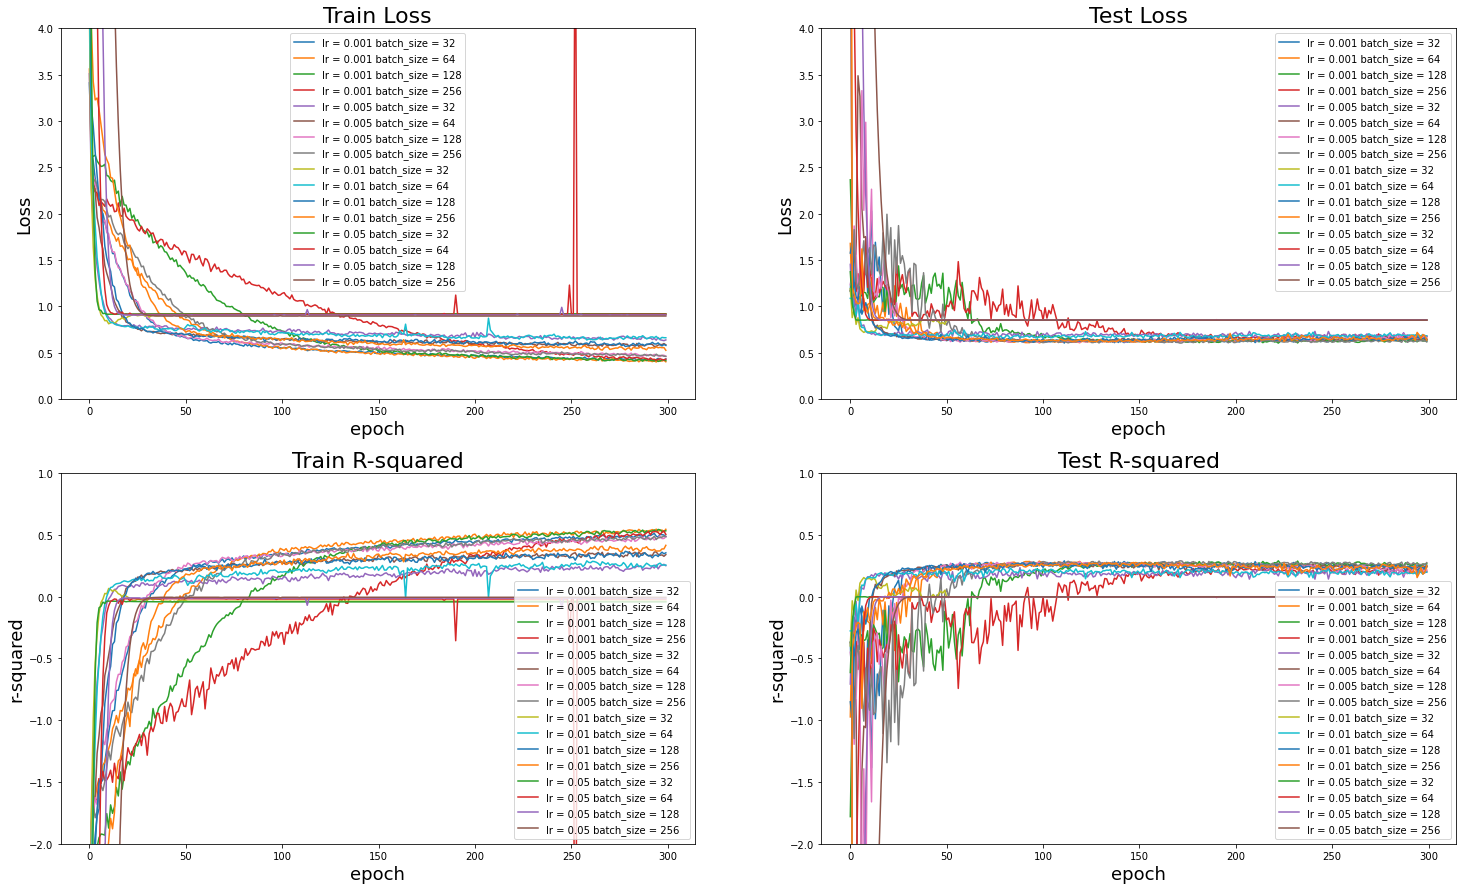

<Figure size 1800x1080 with 0 Axes>

In [18]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 4])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 4])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-2,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-2,1])

plt.show()

In [19]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   

0.485868384998752
0.5459481073139203
0.533671161640358
0.5040220496696493
0.251060338181269
0.34067122414653783
0.4848733171428351
0.4883021927455982
-0.036543617912526284
0.2563310607099049
0.35534926611699
0.41590191538174526
-0.04178920230651121
-0.018703754157370262
-0.010976904725329353
-0.004940895533717867
___________________

0.255546009318531
0.23527495974996537
0.2678955795505248
0.2081567466043639
0.20089964002995986
0.24532213870497954
0.21729411168371493
0.27549058548209826
-0.000711973620474815
0.19793877522885384
0.24402436334905264
0.2525274687634428
-0.0024772558819137203
-0.00014401999835755852
-0.001799076987974102
-3.0682363771905585e-06
___________________

0.43206938039591386
0.40210806215420747
0.41457488526732234
0.4308741291364034
0.6380341281962497
0.584848342033533
0.4598158395896524
0.461247351889809
0.9160200795518482
0.6615381577076056
0.5788905946380001
0.5263978863755862
0.9196295939673682
0.9154093406903439
0.9075748511290146
0.8958796108762423
________

### 2 best models

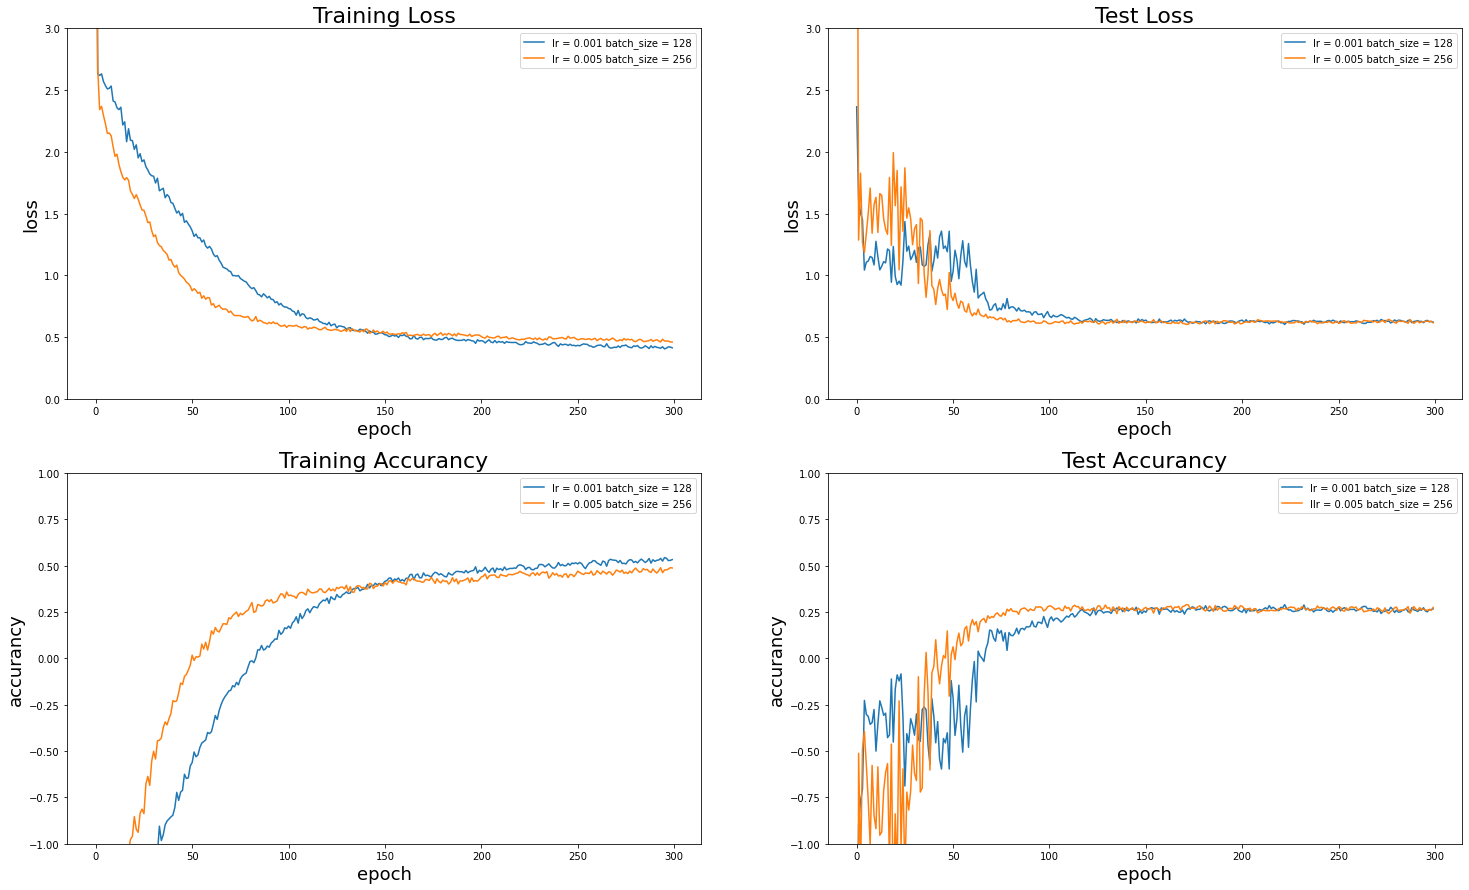

<Figure size 432x288 with 0 Axes>

In [20]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Training Loss", fontsize=22)
ax1.plot(train_losses_all[2],label="lr = 0.001 batch_size = 128")
ax1.plot(train_losses_all[7],label="lr = 0.005 batch_size = 256")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 3])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[2],label="lr = 0.001 batch_size = 128")
ax2.plot(test_losses_all[7],label="lr = 0.005 batch_size = 256")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 3])

ax3.set_title("Training Accurancy", fontsize=22)
ax3.plot(train_accs_all[2],label="lr = 0.001 batch_size = 128")
ax3.plot(train_accs_all[7],label="lr = 0.005 batch_size = 256")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("accurancy", fontsize=18)
ax3.legend()
ax3.set_ylim([-1,1])

ax4.set_title("Test Accurancy", fontsize=22)
ax4.plot(test_accs_all[2],label="lr = 0.001 batch_size = 128")
ax4.plot(test_accs_all[7],label="llr = 0.005 batch_size = 256")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("accurancy", fontsize=18)
ax4.legend()
ax4.set_ylim([-1,1])
plt.show()

## 4.2. Training

In [15]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=2127, shuffle=False)

In [16]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.005)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/cardio_pubchem_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 8.109934897983775, Accuracy: -8.123442511552886
Test Avg. loss: 9.750664710998535, Accuracy: -9.889389212513692
################## EPOCH 2 ##################
Train Avg. loss: 3.0521045572617473, Accuracy: -2.4357925602116643
Test Avg. loss: 1.66676926612854, Accuracy: -0.8614216197899098
################## EPOCH 3 ##################
Train Avg. loss: 2.737037546494428, Accuracy: -2.080189715247221
Test Avg. loss: 1.3411657810211182, Accuracy: -0.49779275762214503
################## EPOCH 4 ##################
Train Avg. loss: 2.708964733516469, Accuracy: -2.0467114209215533
Test Avg. loss: 1.575979232788086, Accuracy: -0.7600288383462535
################## EPOCH 5 ##################
Train Avg. loss: 2.5464644397006317, Accuracy: -1.8537880745208517
Test Avg. loss: 1.208069086074829, Accuracy: -0.3491523859949206
################## EPOCH 6 ##################
Train Avg. loss: 2.55375733796288, Accuracy: -1.8815373974273464
Test

Train Avg. loss: 0.9060139989151674, Accuracy: -0.00863364648573854
Test Avg. loss: 0.7576459050178528, Accuracy: 0.15387299885146888
################## EPOCH 48 ##################
Train Avg. loss: 0.8766499196781832, Accuracy: 0.01970840461486185
Test Avg. loss: 0.7445089817047119, Accuracy: 0.16854412948349573
################## EPOCH 49 ##################
Train Avg. loss: 0.8677641959751353, Accuracy: 0.03142231240811452
Test Avg. loss: 0.7664310336112976, Accuracy: 0.14406199916282902
################## EPOCH 50 ##################
Train Avg. loss: 0.8569164889700273, Accuracy: 0.04091521058892349
Test Avg. loss: 0.74124675989151, Accuracy: 0.17218730977105556
################## EPOCH 51 ##################
Train Avg. loss: 0.8432795002179987, Accuracy: 0.05624062144273373
Test Avg. loss: 0.7298938035964966, Accuracy: 0.1848661525617168
################## EPOCH 52 ##################
Train Avg. loss: 0.836401409962598, Accuracy: 0.06312227465049398
Test Avg. loss: 0.7288306355476379, 

Train Avg. loss: 0.6053803010898477, Accuracy: 0.3256551141392317
Test Avg. loss: 0.6873007416725159, Accuracy: 0.23243339541143393
################## EPOCH 94 ##################
Train Avg. loss: 0.6088311514433693, Accuracy: 0.3217539811057753
Test Avg. loss: 0.68918776512146, Accuracy: 0.23032604864884598
################## EPOCH 95 ##################
Train Avg. loss: 0.601314499097712, Accuracy: 0.3282014927838839
Test Avg. loss: 0.6991220116615295, Accuracy: 0.21923158239633578
################## EPOCH 96 ##################
Train Avg. loss: 0.5899798922679004, Accuracy: 0.34342830122985873
Test Avg. loss: 0.6927928328514099, Accuracy: 0.22629998875462742
################## EPOCH 97 ##################
Train Avg. loss: 0.5910001738983042, Accuracy: 0.34187542350723193
Test Avg. loss: 0.686601996421814, Accuracy: 0.23321370327405144
################## EPOCH 98 ##################
Train Avg. loss: 0.597775292747161, Accuracy: 0.3343565434512287
Test Avg. loss: 0.6844729781150818, Accura

Train Avg. loss: 0.5637696332791272, Accuracy: 0.37355989030765835
Test Avg. loss: 0.6929954290390015, Accuracy: 0.22607373252592122
################## EPOCH 140 ##################
Train Avg. loss: 0.5589144427110168, Accuracy: 0.3796052139517624
Test Avg. loss: 0.68581223487854, Accuracy: 0.23409571019744724
################## EPOCH 141 ##################
Train Avg. loss: 0.5528062354115879, Accuracy: 0.3833824001713307
Test Avg. loss: 0.6936217546463013, Accuracy: 0.22537412214075514
################## EPOCH 142 ##################
Train Avg. loss: 0.5646787303335526, Accuracy: 0.3696593810565642
Test Avg. loss: 0.6957733631134033, Accuracy: 0.22297130250113262
################## EPOCH 143 ##################
Train Avg. loss: 0.5502769627115306, Accuracy: 0.38853935020824404
Test Avg. loss: 0.6886605024337769, Accuracy: 0.2309148059480124
################## EPOCH 144 ##################
Train Avg. loss: 0.5688744976240045, Accuracy: 0.367515094883462
Test Avg. loss: 0.6983310580253601, 

Train Avg. loss: 0.5396878592231694, Accuracy: 0.3993547488673574
Test Avg. loss: 0.6705875992774963, Accuracy: 0.25109833392642844
################## EPOCH 186 ##################
Train Avg. loss: 0.5407267375027432, Accuracy: 0.39926924139275394
Test Avg. loss: 0.6684888005256653, Accuracy: 0.25344232607382666
################## EPOCH 187 ##################
Train Avg. loss: 0.5313521518426783, Accuracy: 0.4100756087114159
Test Avg. loss: 0.6698002815246582, Accuracy: 0.2519776539808305
################## EPOCH 188 ##################
Train Avg. loss: 0.5343954637646675, Accuracy: 0.40748749589961064
Test Avg. loss: 0.6669501662254333, Accuracy: 0.2551605156480643
################## EPOCH 189 ##################
Train Avg. loss: 0.5330613658708685, Accuracy: 0.4060863606190774
Test Avg. loss: 0.6691491007804871, Accuracy: 0.252704815866158
################## EPOCH 190 ##################
Train Avg. loss: 0.5253453149515039, Accuracy: 0.41596745885927155
Test Avg. loss: 0.6675606966018677,

Train Avg. loss: 0.5087361353285172, Accuracy: 0.43252403835656644
Test Avg. loss: 0.6870532631874084, Accuracy: 0.23270973109009008
################## EPOCH 232 ##################
Train Avg. loss: 0.5127119921586093, Accuracy: 0.4287383470556779
Test Avg. loss: 0.6738641858100891, Accuracy: 0.2474391564910582
################## EPOCH 233 ##################
Train Avg. loss: 0.5154296615544487, Accuracy: 0.42718435813529476
Test Avg. loss: 0.679246723651886, Accuracy: 0.24142797770363944
################## EPOCH 234 ##################
Train Avg. loss: 0.5198390019290587, Accuracy: 0.4197368819589274
Test Avg. loss: 0.6746783256530762, Accuracy: 0.2465299389725507
################## EPOCH 235 ##################
Train Avg. loss: 0.5136023527559113, Accuracy: 0.4293342740309544
Test Avg. loss: 0.6761173605918884, Accuracy: 0.24492281128449211
################## EPOCH 236 ##################
Train Avg. loss: 0.49650372301830964, Accuracy: 0.44632315801128053
Test Avg. loss: 0.681526184082031

Train Avg. loss: 0.49640659462003145, Accuracy: 0.44727832157117603
Test Avg. loss: 0.6661956906318665, Accuracy: 0.256003229784846
################## EPOCH 278 ##################
Train Avg. loss: 0.48841292323435054, Accuracy: 0.4573132881950055
Test Avg. loss: 0.6758627891540527, Accuracy: 0.24520710161214443
################## EPOCH 279 ##################
Train Avg. loss: 0.4941099286079407, Accuracy: 0.4499092644101628
Test Avg. loss: 0.6699376106262207, Accuracy: 0.2518242794830068
################## EPOCH 280 ##################
Train Avg. loss: 0.4951861763701719, Accuracy: 0.4485776081662237
Test Avg. loss: 0.6766571402549744, Accuracy: 0.2443200172448049
################## EPOCH 281 ##################
Train Avg. loss: 0.4863164367921212, Accuracy: 0.4579516314996395
Test Avg. loss: 0.6733579635620117, Accuracy: 0.24800447884498233
################## EPOCH 282 ##################
Train Avg. loss: 0.4899623674504897, Accuracy: 0.45348319140238835
Test Avg. loss: 0.6744535565376282

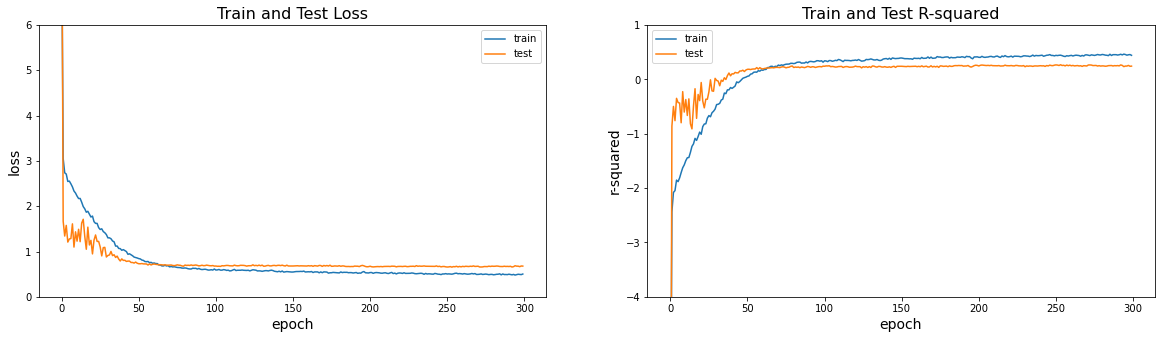

<Figure size 1440x360 with 0 Axes>

In [19]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.set_ylim([0, 6])
ax1.legend()

ax2.set_title("Train and Test R-squared", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("r-squared", fontsize=14)
ax2.set_ylim([-4, 1])
ax2.legend()
plt.show()

In [20]:
model = FCNN()
model.load_state_dict(torch.load('../../models/cardio_pubchem_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 0.586352
MSE: 0.654653
RMSE: 0.8091063
R2 Square 0.2688939100374721 

